<a href="https://www.kaggle.com/code/chinmaygope/diabetes-pred-2?scriptVersionId=194359643" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-data-set/diabetes.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
import warnings
warnings.simplefilter(action='ignore')
sns.set()
plt.style.use("ggplot")
%matplotlib inline

In [3]:
df = pd.read_csv('/kaggle/input/diabetes-data-set/diabetes.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [6]:
df.shape

(768, 9)

In [7]:
df.Outcome.value_counts()*100 / len(df)

Outcome
0    65.104167
1    34.895833
Name: count, dtype: float64

<Axes: xlabel='Age', ylabel='Count'>

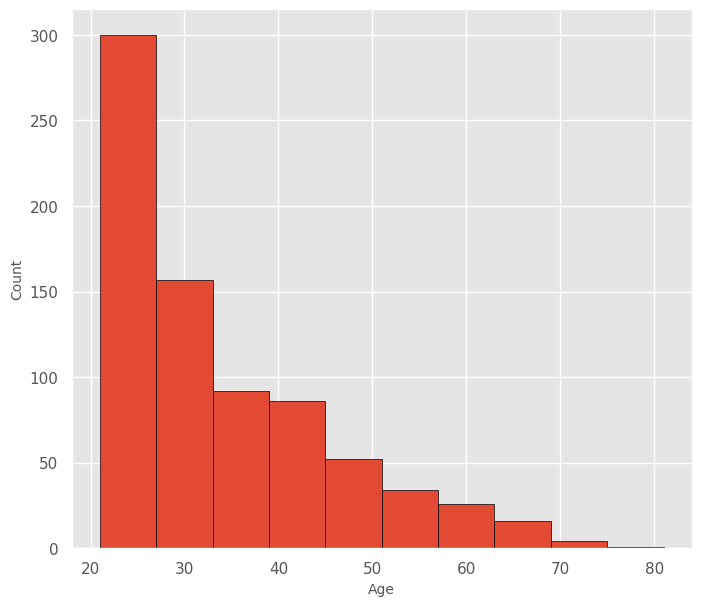

In [8]:
plt.figure(figsize=(8,7))
plt.xlabel('Age', fontsize=10)
plt.ylabel('Count', fontsize=10)
df.Age.hist(edgecolor='black')

In [9]:
df.Age.max()

81

In [10]:
df.Age.min()

21

In [11]:
print("MAX AGE: "+str(df.Age.max()))
print("MIN AGE: "+str(df.Age.min()))

MAX AGE: 81
MIN AGE: 21


# **Density Graph** 

In [12]:
def plot_density_graph(df):
    fig, ax = plt.subplots(4, 2, figsize=(20, 20))
     # Define the features to plot
    features = ['Pregnancies', 'Glucose', 'BloodPressure', 
                'SkinThickness', 'Insulin', 'BMI', 
                'DiabetesPedigreeFunction', 'Age']
    
    # Plot histograms with KDE for each feature
    for i, feature in enumerate(features):
        sns.histplot(df[feature], bins=20, ax=ax[i//2, i%2], 
                     color='red', kde=True, edgecolor='black', stat='density')
    
    plt.tight_layout()
    plt.show()

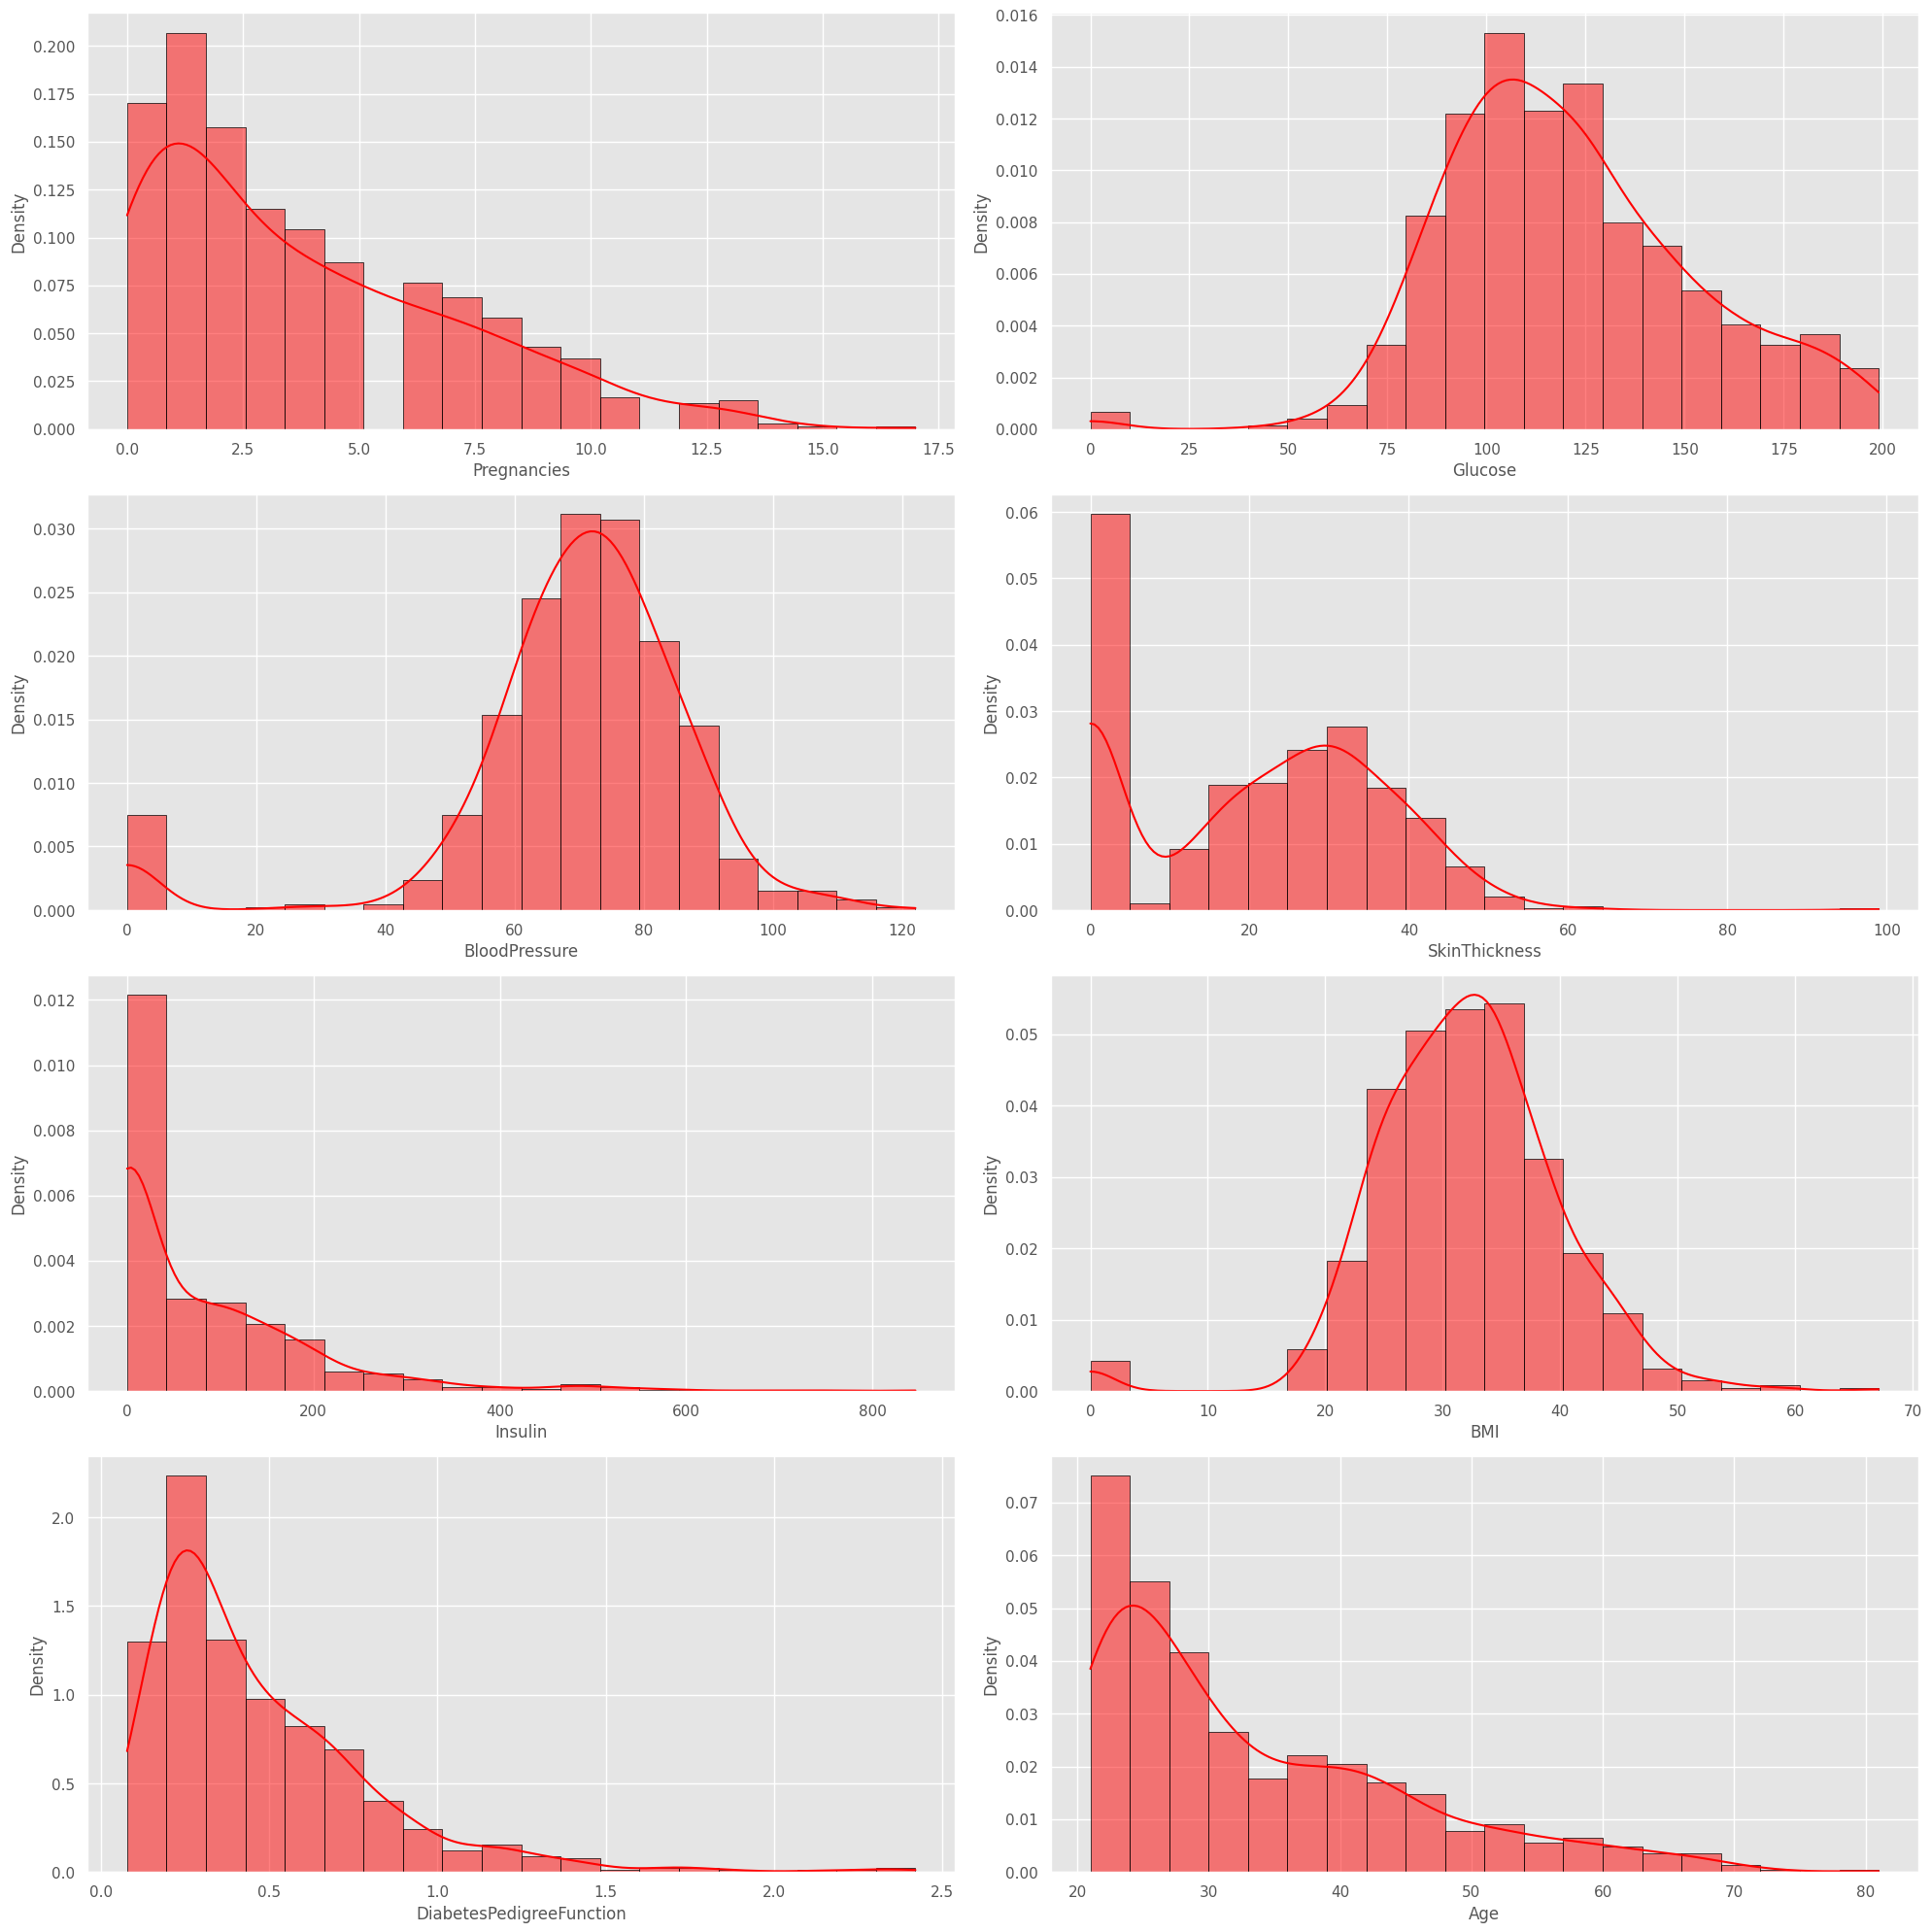

In [13]:
plot_density_graph(df)

# **Mean and Max values**

In [14]:
df.groupby('Outcome').agg({'Pregnancies':'mean'})

Pregnancies
Outcome             
0           3.298000
1           4.865672

In [15]:
df.groupby('Outcome').agg({'Pregnancies':'max'})

Pregnancies
Outcome             
0                 13
1                 17

In [16]:
df.groupby('Outcome').agg({'Glucose':'mean'})

Glucose
Outcome            
0        109.980000
1        141.257463

In [17]:
df.groupby('Outcome').agg({'Glucose':'max'})

Glucose
Outcome         
0            197
1            199

In [18]:
df.groupby('Outcome').agg({'BloodPressure':'max'})

BloodPressure
Outcome               
0                  122
1                  114

In [19]:
df.groupby('Outcome').agg({'BloodPressure':'mean'})

BloodPressure
Outcome               
0            68.184000
1            70.824627

In [20]:
df.groupby('Outcome').agg({'SkinThickness':'mean'})

SkinThickness
Outcome               
0            19.664000
1            22.164179

In [21]:
df.groupby('Outcome').agg({'SkinThickness':'max'})

SkinThickness
Outcome               
0                   60
1                   99

In [22]:
df.groupby('Outcome').agg({'Insulin':'mean'})

Insulin
Outcome            
0         68.792000
1        100.335821

In [23]:
df.groupby('Outcome').agg({'Insulin':'max'})

Insulin
Outcome         
0            744
1            846

In [24]:
df.groupby('Outcome').agg({'BMI':'max'})

BMI
Outcome      
0        57.3
1        67.1

In [25]:
df.groupby('Outcome').agg({'BMI':'mean'})

BMI
Outcome           
0        30.304200
1        35.142537

In [26]:
df.groupby('Outcome').agg({'Age':'mean'})

Age
Outcome           
0        31.190000
1        37.067164

In [27]:
df.groupby('Outcome').agg({'Age':'mean'})

Age
Outcome           
0        31.190000
1        37.067164

In [28]:
df.groupby('Outcome').agg({'DiabetesPedigreeFunction':'mean'})

DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500

In [29]:
df.groupby('Outcome').agg({'DiabetesPedigreeFunction':'max'})

DiabetesPedigreeFunction
Outcome                          
0                           2.329
1                           2.420

In [30]:
attribute =  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [31]:
def plot_all_attributes_stats(df,attr,color_mean):
    # Calculate mean and max for Pregnancies grouped by Outcome
    mean_attr = df.groupby('Outcome').agg({attr : 'mean'}).reset_index()
    max_attr = df.groupby('Outcome').agg({ attr: 'max'}).reset_index()

    # Merge the two dataframes on Outcome
    stats_df = pd.merge(mean_attr, max_attr, on='Outcome', suffixes=('_mean', '_max'))

    # Plotting
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = stats_df['Outcome']
    
   # Plotting mean values
    bars1 = plt.bar(index - bar_width/2, stats_df[f'{attr}_mean'], bar_width, 
                    label=f'Mean {attr}', color=color_mean)
    
    # Plotting max values
    bars2 = plt.bar(index + bar_width/2, stats_df[f'{attr}_max'], bar_width, 
                    label='Max Pregnancies', color='blue')
    
    # Annotating the bars with the respective values
    for bar in bars1:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{bar.get_height():.2f}', ha ='center', va ='bottom')
    
    for bar in bars2:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{bar.get_height():.2f}', ha ='center', va ='bottom')
    
    plt.xlabel('Outcome')
    plt.ylabel(f'{attr}')
    plt.title(f'Mean and Max {attr} by Outcome')
    plt.xticks(index, ['No Diabetes', 'Diabetes'])
    plt.legend()
    
    plt.show()

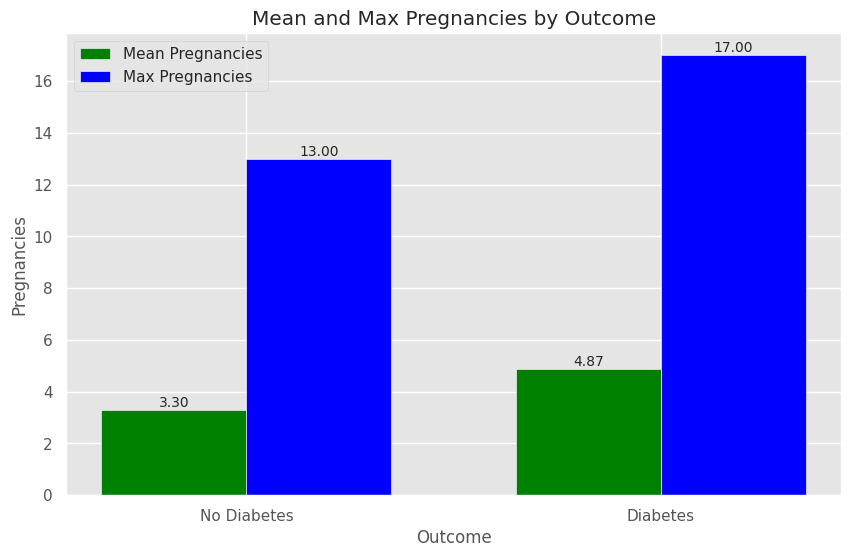

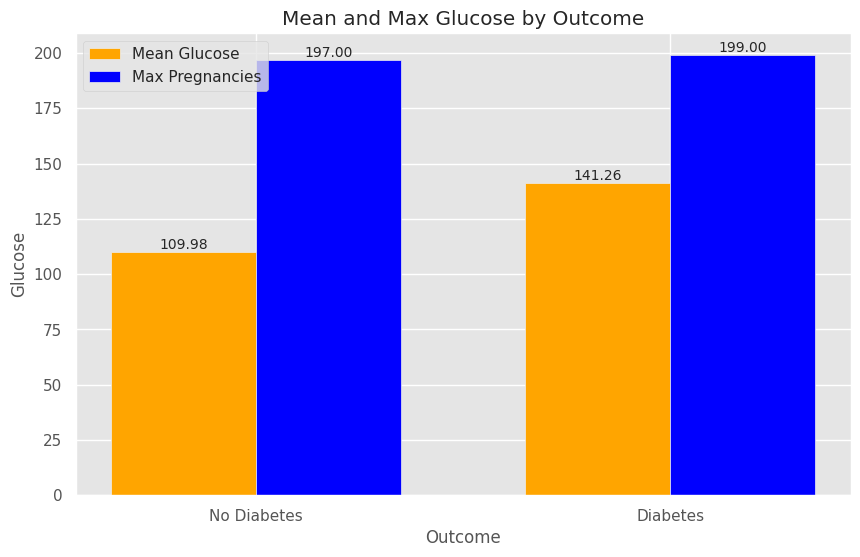

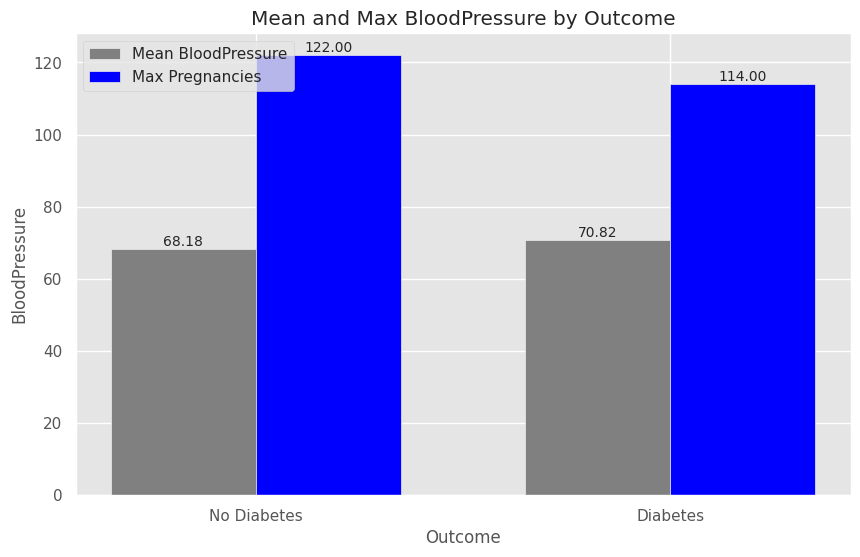

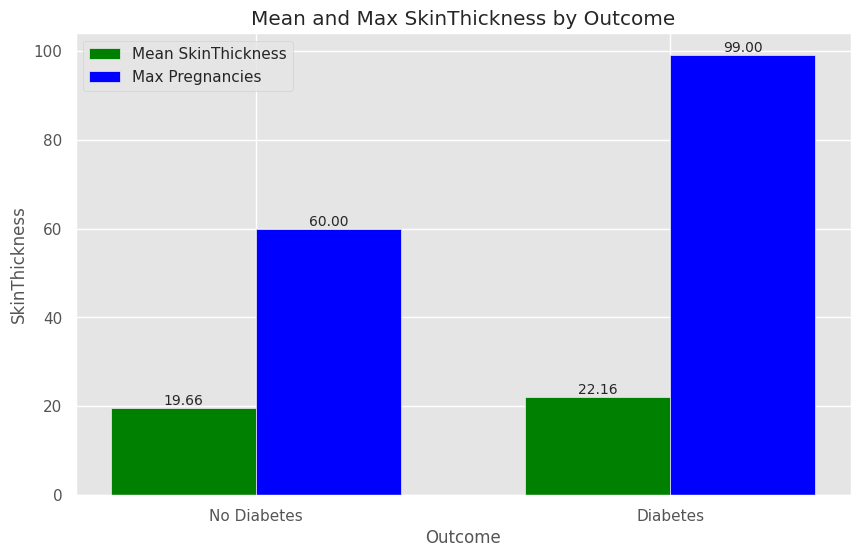

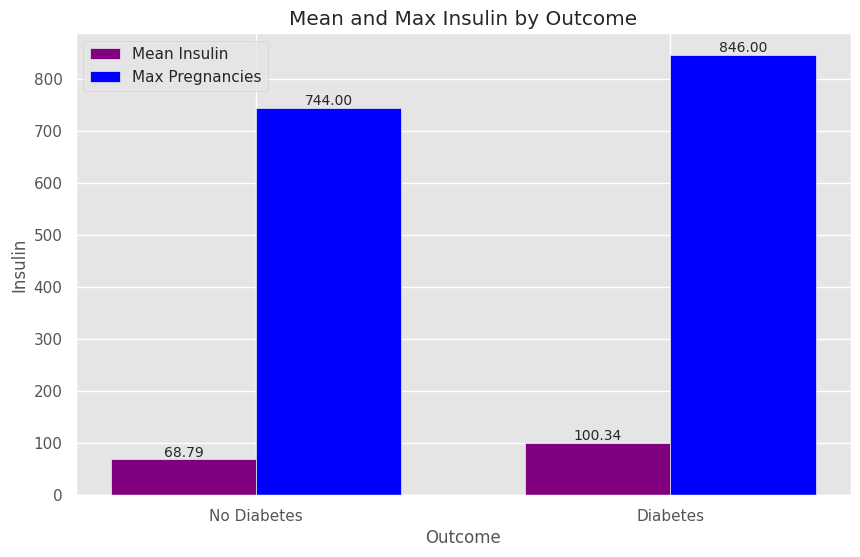

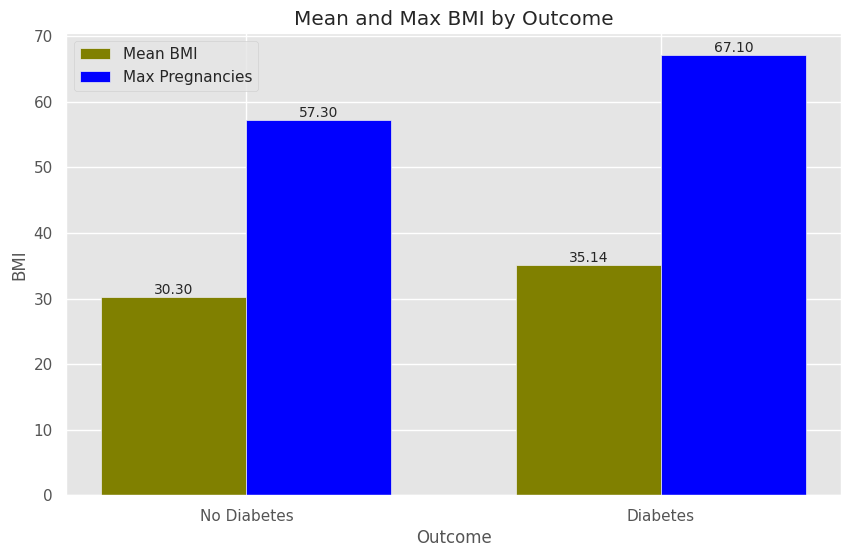

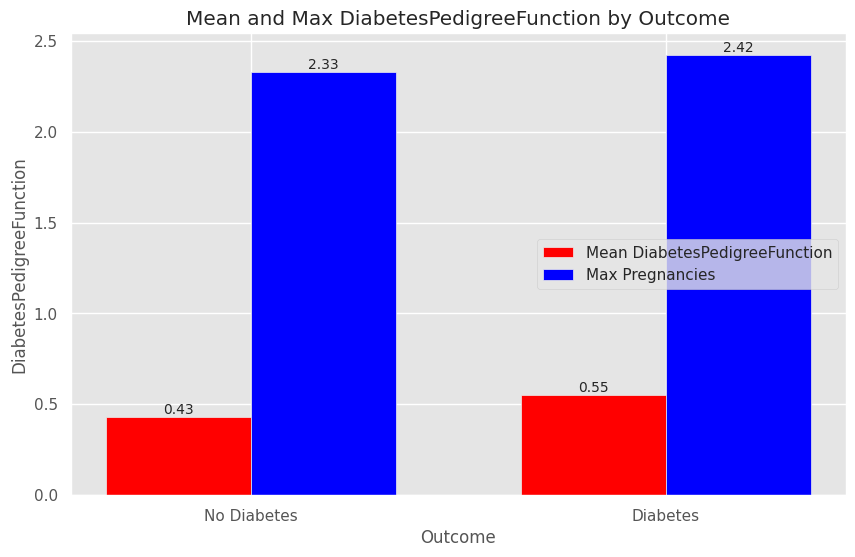

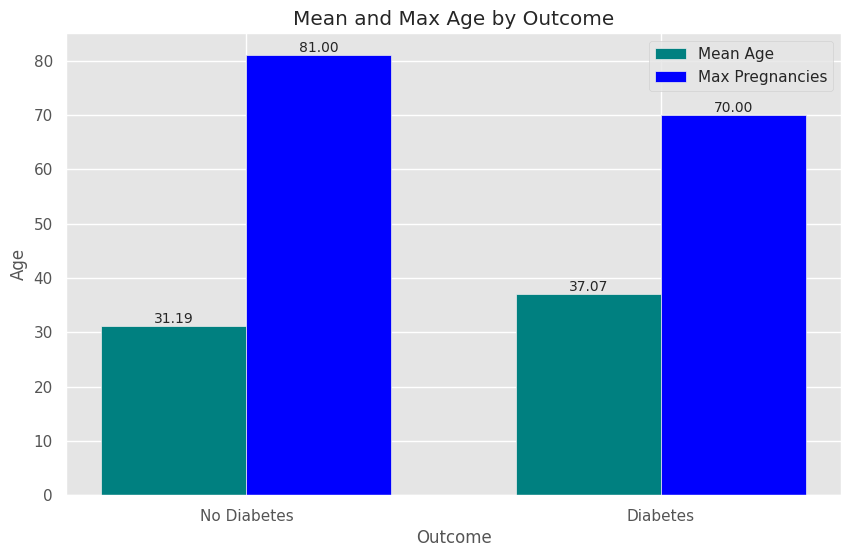

In [32]:
plot_all_attributes_stats(df, 'Pregnancies', color_mean='green')
plot_all_attributes_stats(df, 'Glucose', color_mean='orange')
plot_all_attributes_stats(df, 'BloodPressure', color_mean='grey')
plot_all_attributes_stats(df, 'SkinThickness', color_mean='green')
plot_all_attributes_stats(df, 'Insulin', color_mean='purple')
plot_all_attributes_stats(df, 'BMI', color_mean='olive')
plot_all_attributes_stats(df, 'DiabetesPedigreeFunction', color_mean='red')
plot_all_attributes_stats(df, 'Age', color_mean='teal')

# **Sub plots**

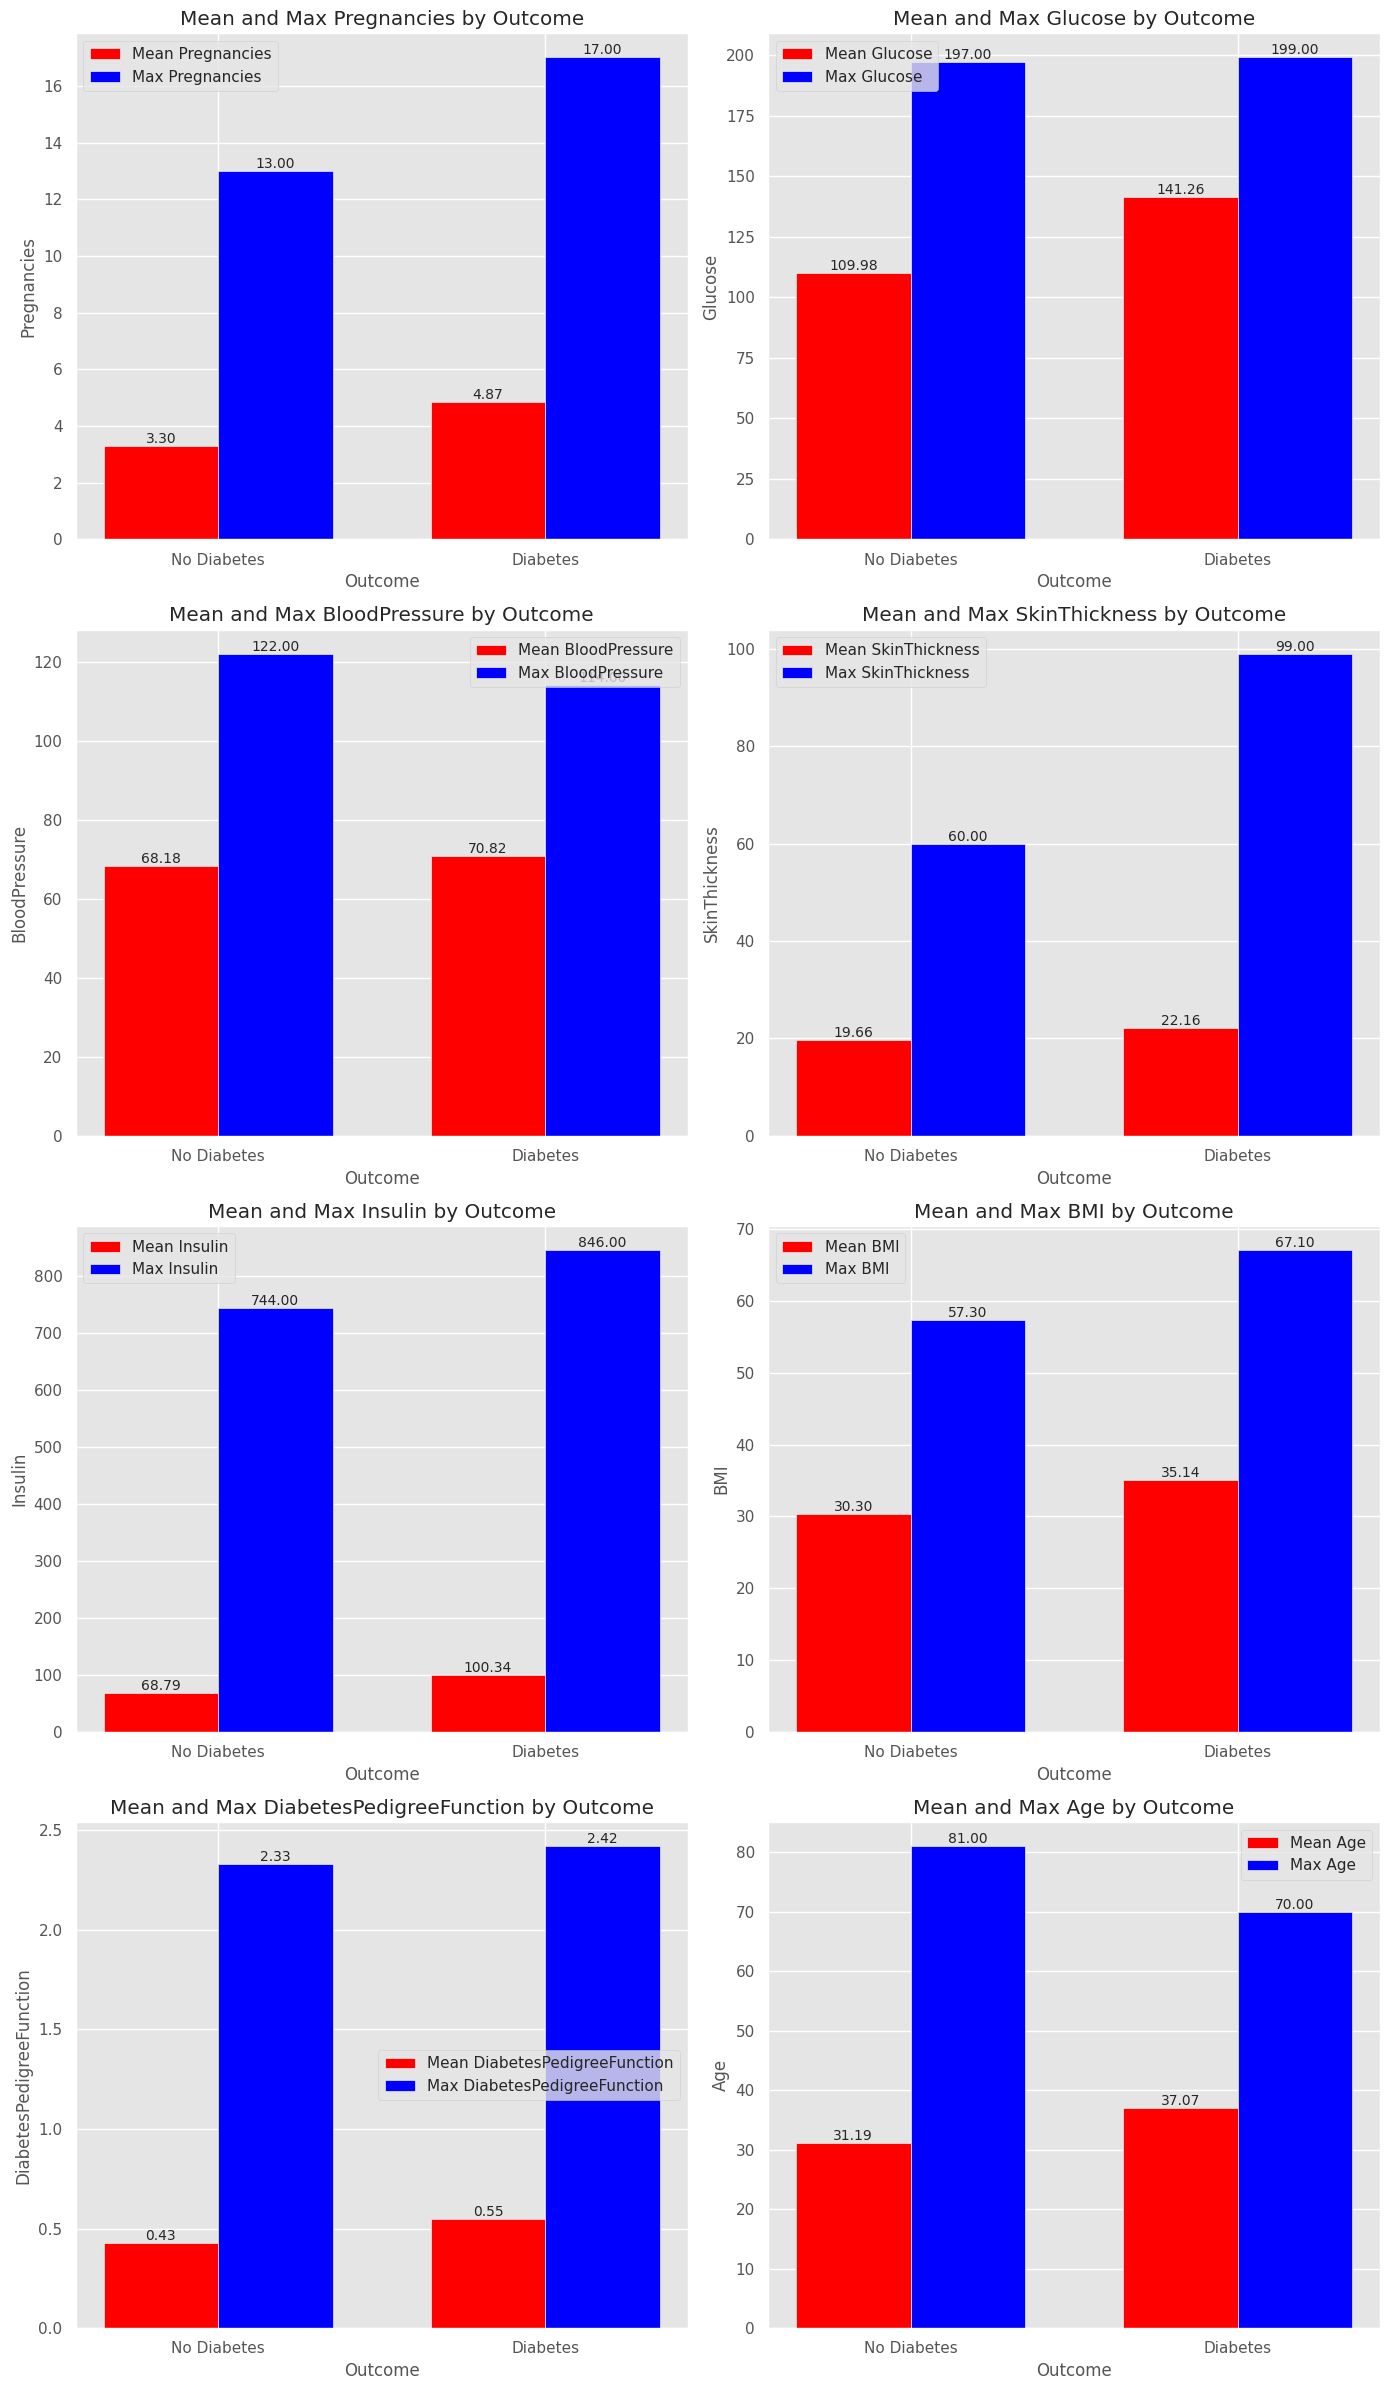

In [33]:
def plot_all_attributes(df, attrs, color_mean):
    num_attributes = len(attrs)
    num_rows = (num_attributes + 1) // 2  # Calculate the number of rows needed (2 per row)
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(14, 6 * num_rows))
    
    # Flatten axes array if there's only one row
    if num_rows == 1:
        axes = axes.reshape(1, 2)
    
    for i, attr in enumerate(attrs):
        # Calculate mean and max for the attribute grouped by Outcome
        mean_attr = df.groupby('Outcome').agg({attr: 'mean'}).reset_index()
        max_attr = df.groupby('Outcome').agg({attr: 'max'}).reset_index()

        # Merge the two dataframes on Outcome
        stats_df = pd.merge(mean_attr, max_attr, on='Outcome', suffixes=('_mean', '_max'))

        # Determine subplot location
        ax = axes[i // 2, i % 2]
        
        # Plotting mean values
        bars1 = ax.bar(stats_df['Outcome'] - 0.35 / 2, stats_df[f'{attr}_mean'], 0.35, 
                       label=f'Mean {attr}', color=color_mean)
        
        # Plotting max values
        bars2 = ax.bar(stats_df['Outcome'] + 0.35 / 2, stats_df[f'{attr}_max'], 0.35, 
                       label='Max ' + attr, color='blue')
        
        # Annotating the bars with the respective values
        for bar in bars1:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    f'{bar.get_height():.2f}', ha='center', va='bottom')
        
        for bar in bars2:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    f'{bar.get_height():.2f}', ha='center', va='bottom')
        
        ax.set_xlabel('Outcome')
        ax.set_ylabel(attr)
        ax.set_title(f'Mean and Max {attr} by Outcome')
        ax.set_xticks(stats_df['Outcome'])
        ax.set_xticklabels(['No Diabetes', 'Diabetes'])
        ax.legend()

    # Remove empty subplots if any
    if num_attributes % 2 != 0:
        fig.delaxes(axes[-1, -1])
    
    plt.tight_layout()
    plt.show()
    
#c   
plot_all_attributes(df, attribute,'red')    

# **Target Column**

In [34]:
# 0 healthy 
# 1 diabetic

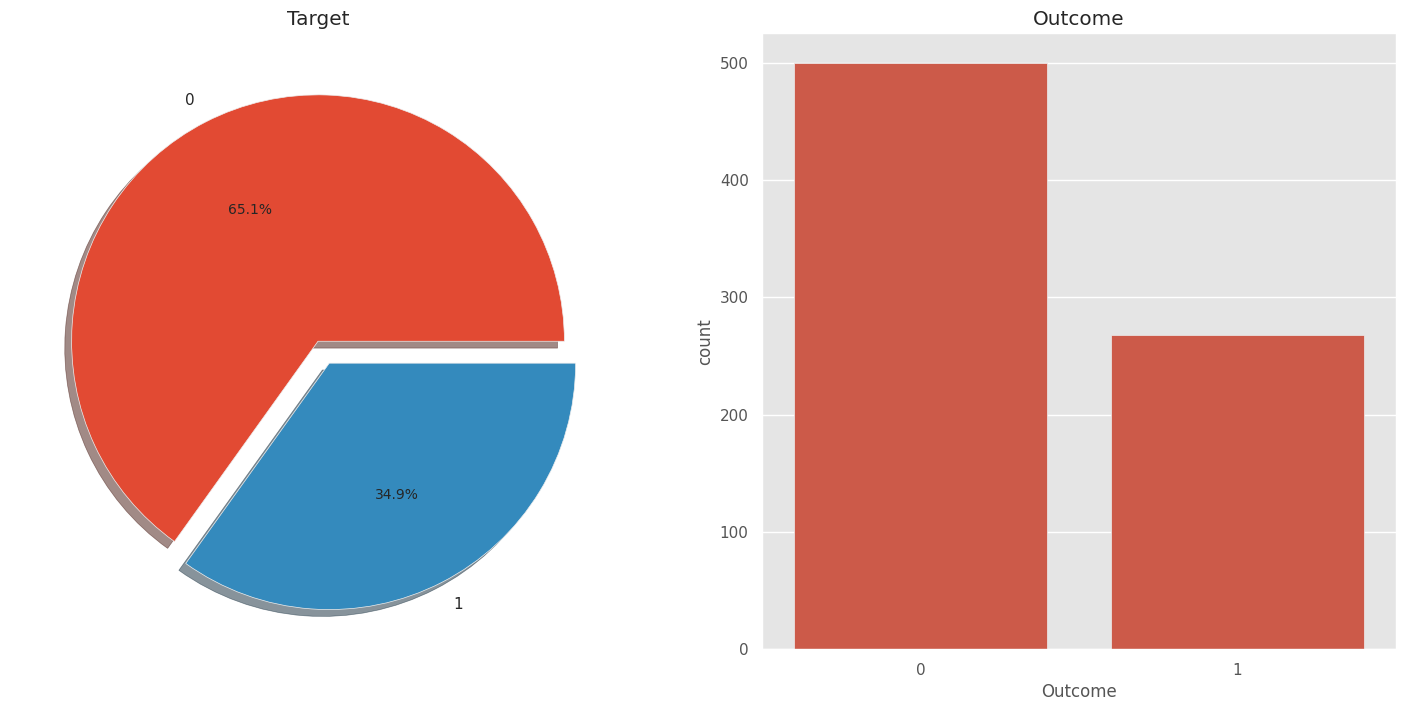

In [35]:
# target - outcome column
f, ax = plt.subplots(1,2, figsize=(18,8))
df.Outcome.value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Target')
ax[0].set_ylabel('')
sns.countplot(x='Outcome', data=df, ax=ax[1])
ax[1].set_title('Outcome')
plt.show()

# **Heatmap**

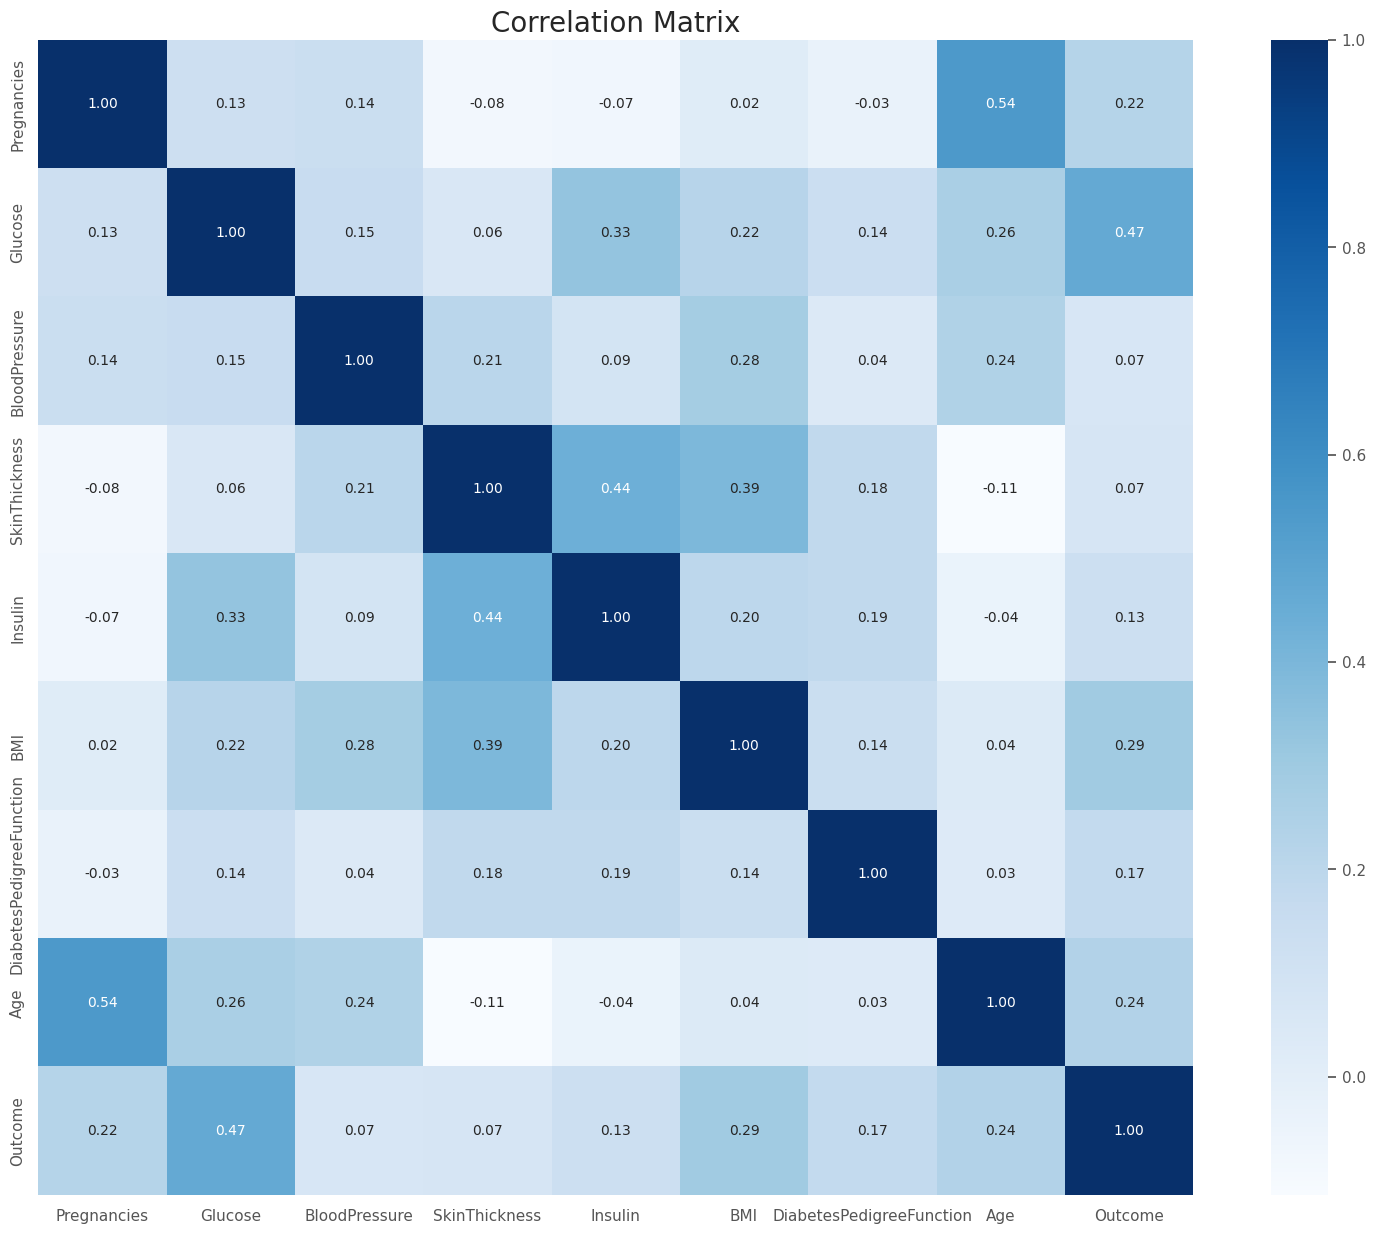

In [36]:
f, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, fmt='.2f', ax=ax, cmap='Blues',square=True)
ax.set_title('Correlation Matrix', fontsize=20)
plt.show()

In [37]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [38]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [39]:
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']] =df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].replace(0,np.NaN)  # technique to find NaN values

In [40]:
df.isnull().sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [41]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0      NaN  33.6   
1          1.0     85.0           66.0           29.0      NaN  26.6   
2          8.0    183.0           64.0            NaN      NaN  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          NaN    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [42]:
pip install missingno


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


<Axes: >

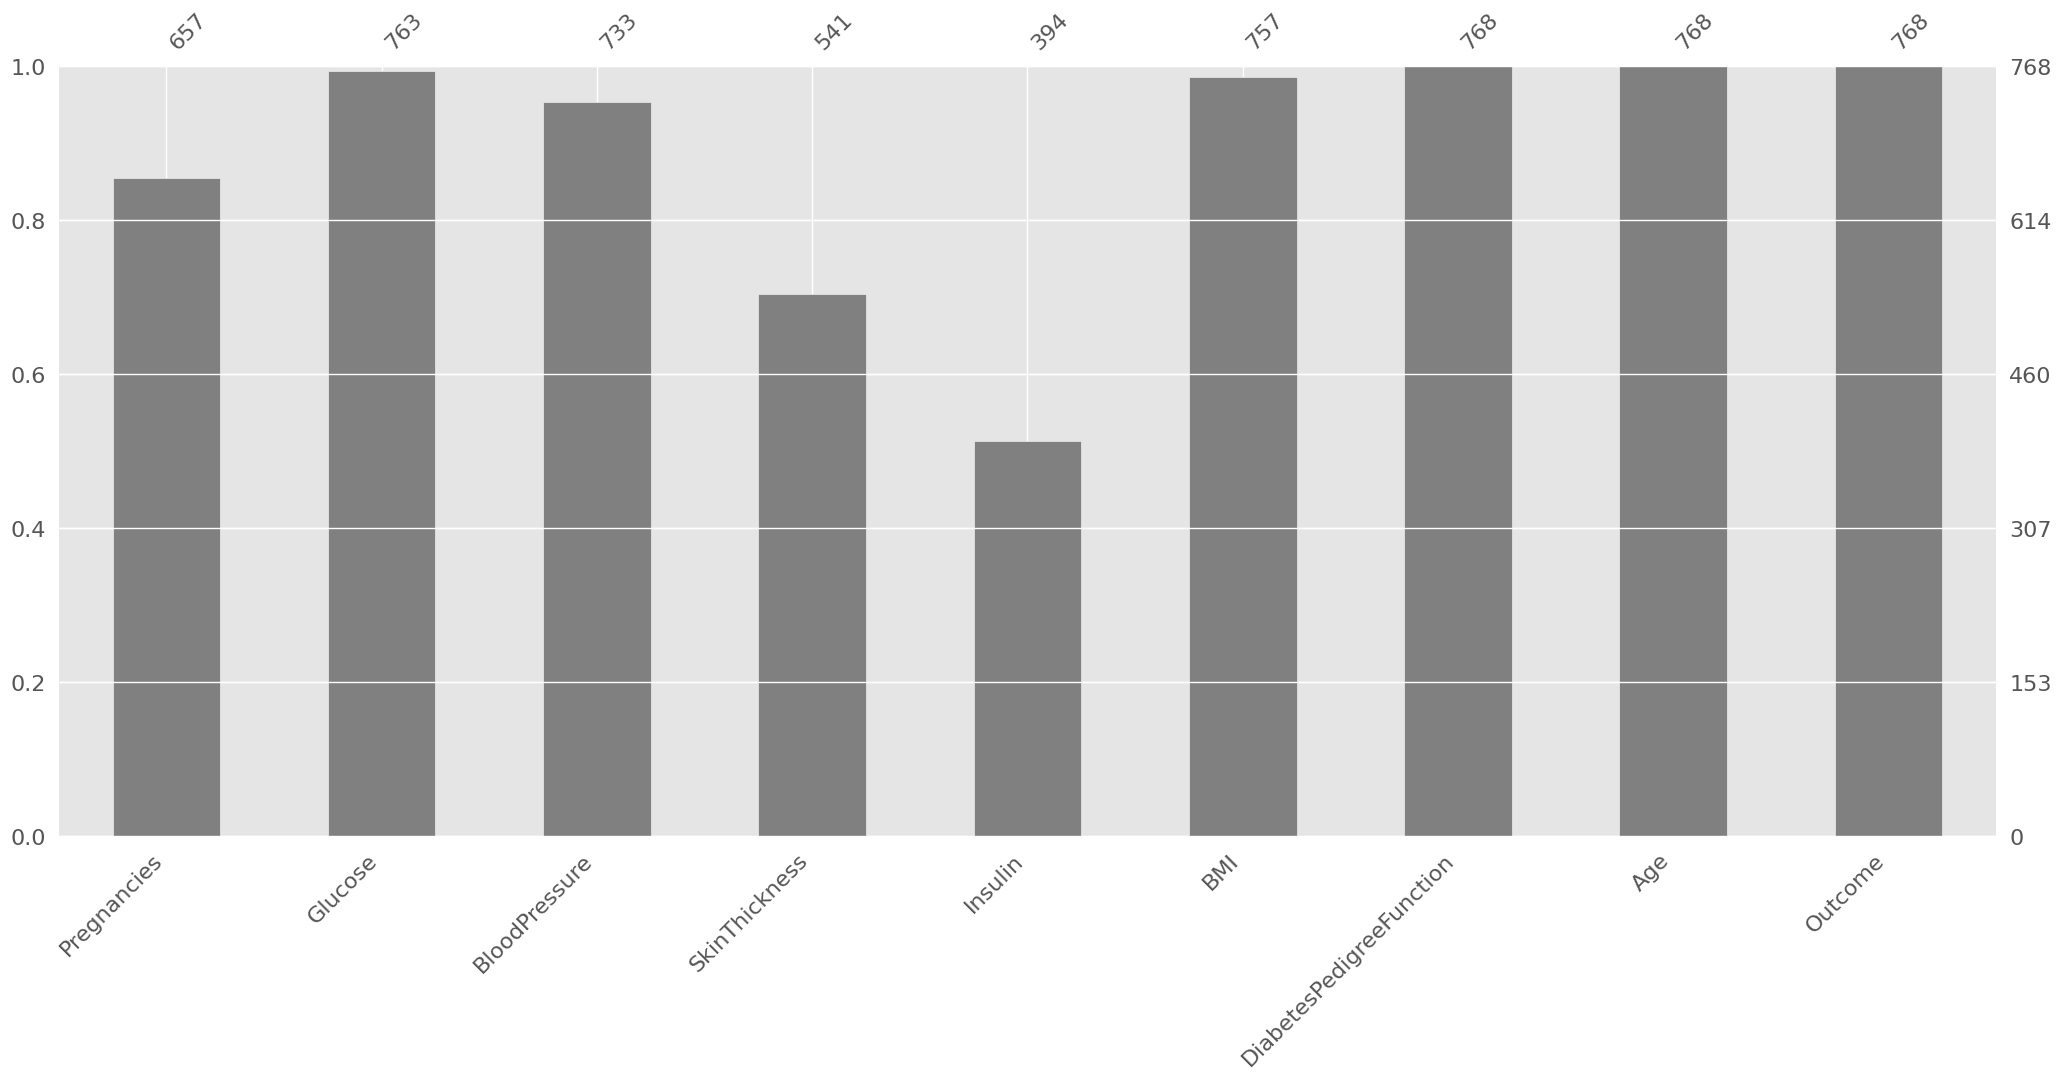

In [43]:
import missingno 
missingno.bar(df,color='grey')

In [44]:
def median_target(var):
    med = df[df[var].notnull()]
    med = med[[var,'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return med

In [45]:
columns = df.columns
columns = columns.drop('Outcome')
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0) & (df[i].isnull()),i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1) & (df[i].isnull()),i] = median_target(i)[i][1]

In [46]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [47]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# **Removing Outliers**

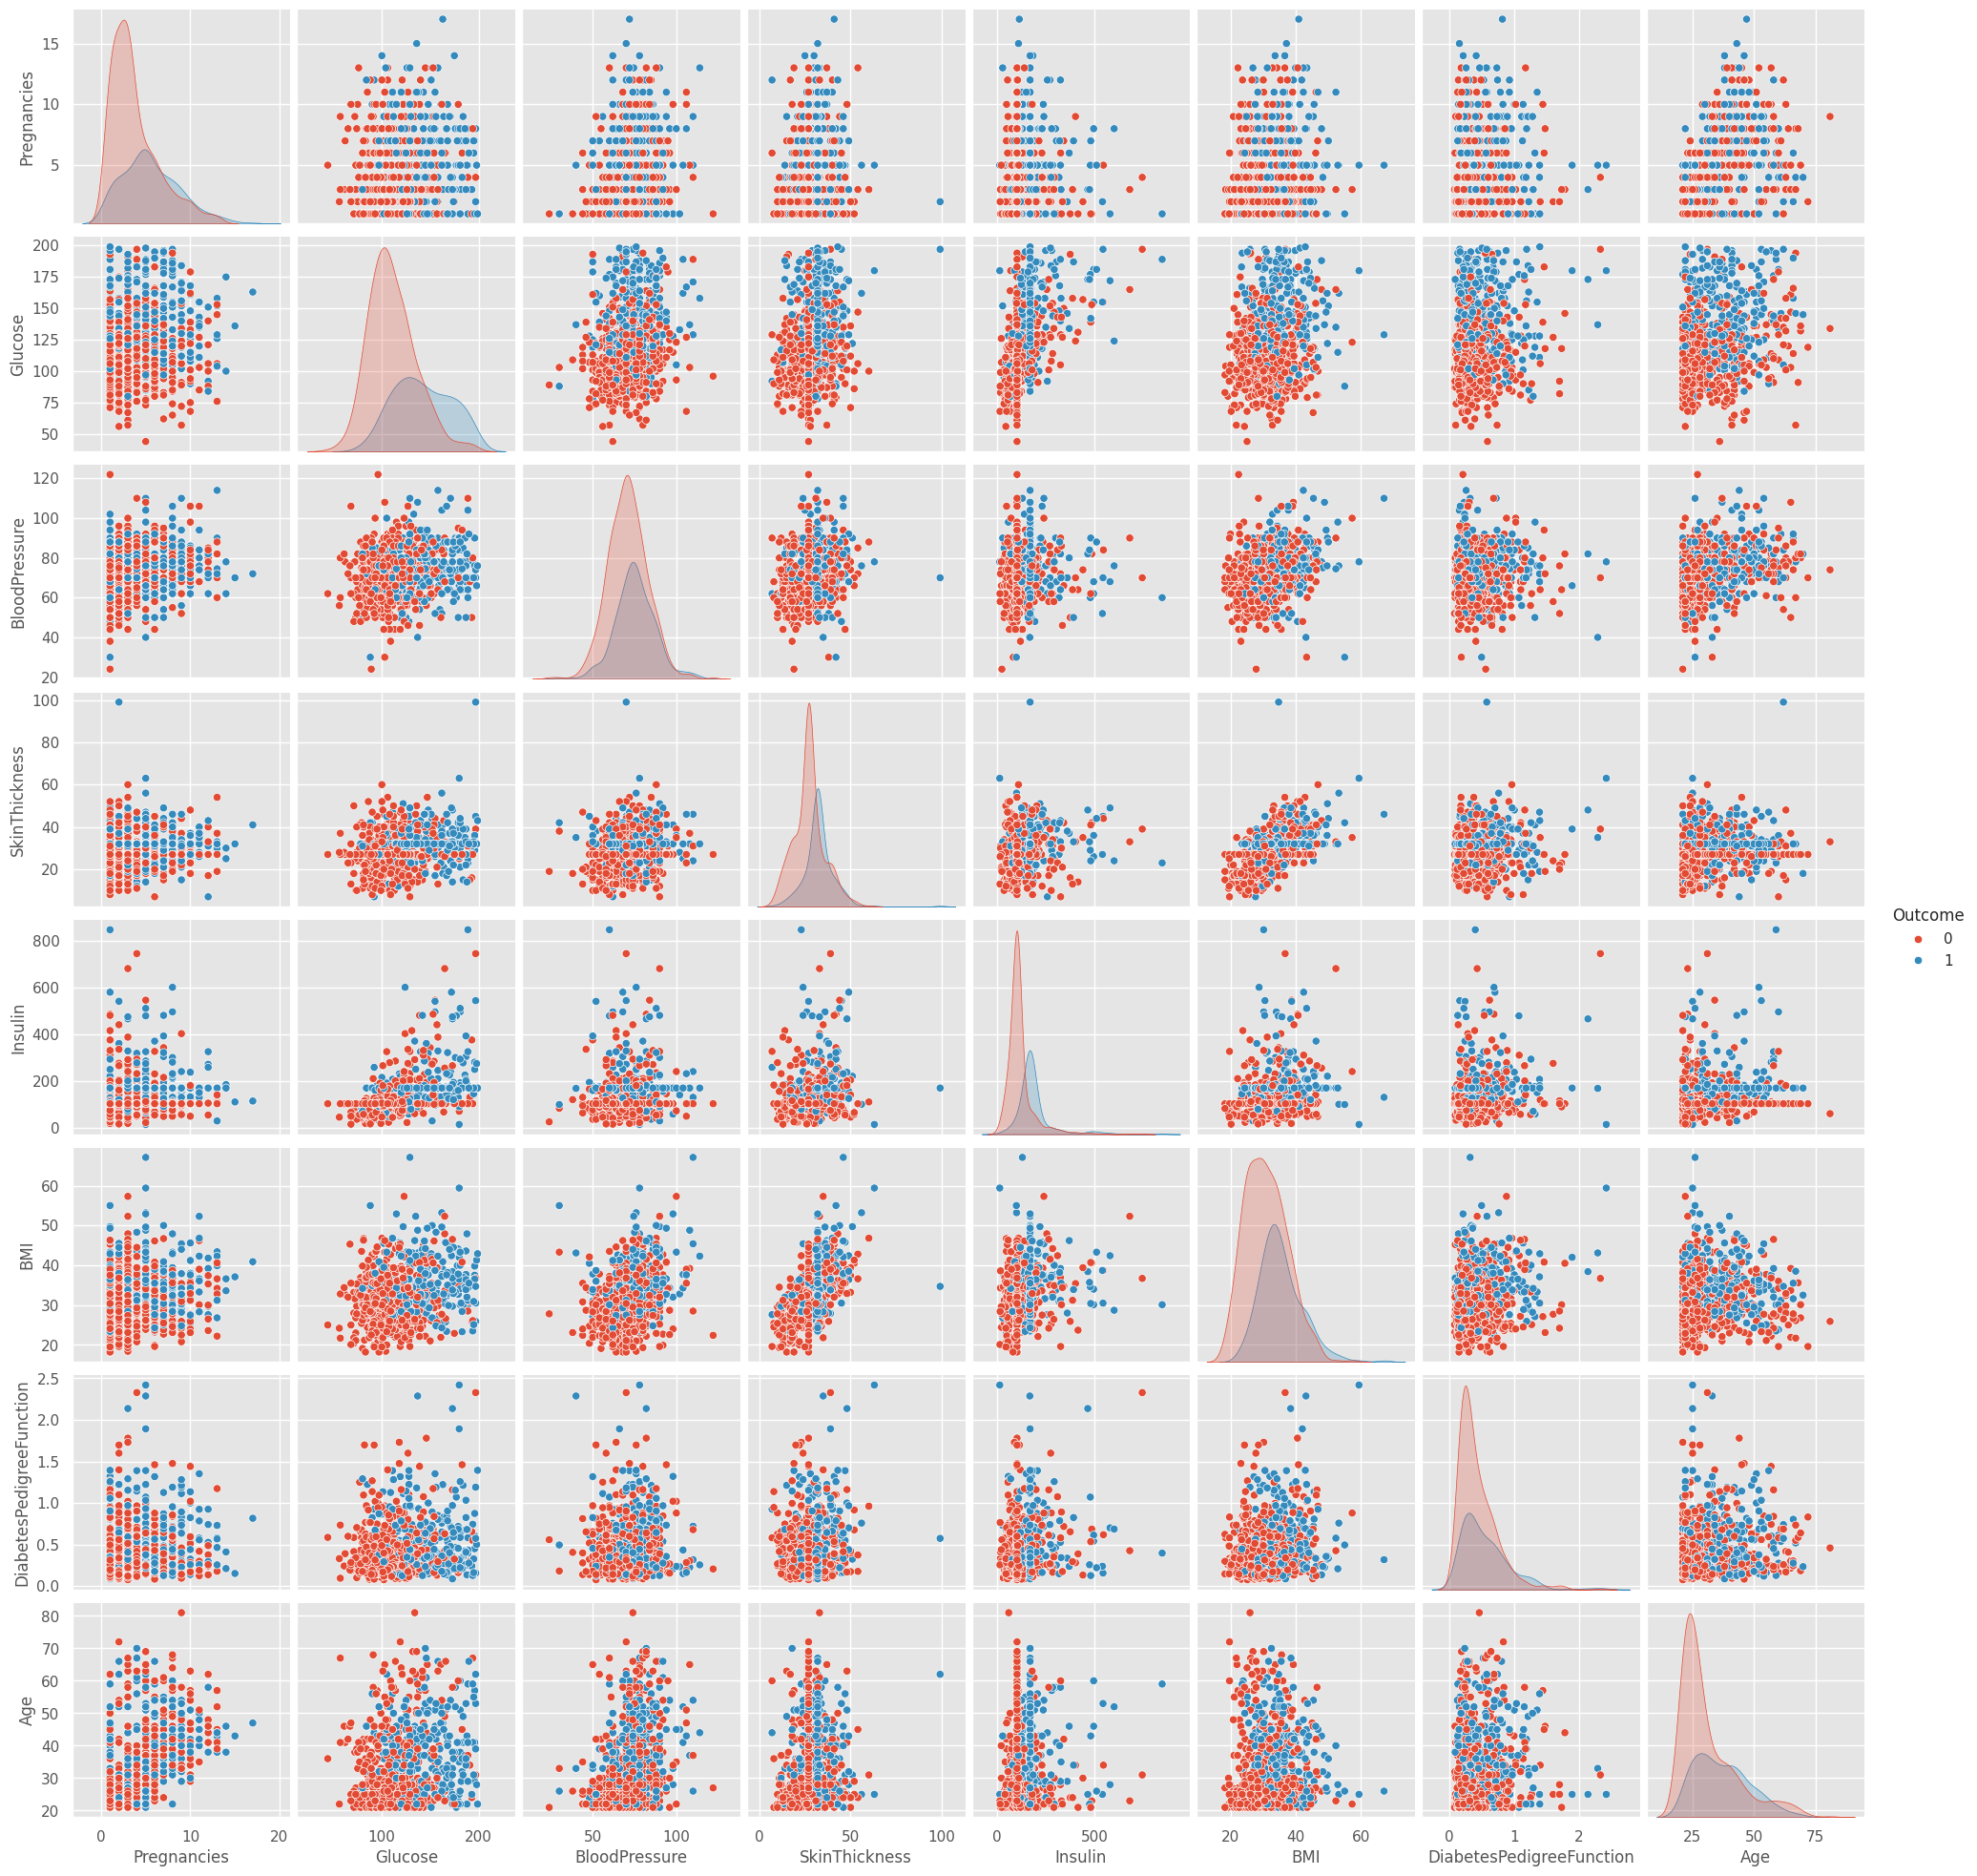

In [48]:
#pairplots
p = sns.pairplot(df,hue='Outcome')

In [49]:
#IQR Interquartile Range 
for feature in df:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)
    print(feature,"YES") if df[(df[feature] > upper)].any(axis=None) else print(feature,"NO")        

Pregnancies YES
Glucose NO
BloodPressure YES
SkinThickness YES
Insulin YES
BMI YES
DiabetesPedigreeFunction YES
Age YES
Outcome NO


<Axes: xlabel='Insulin'>

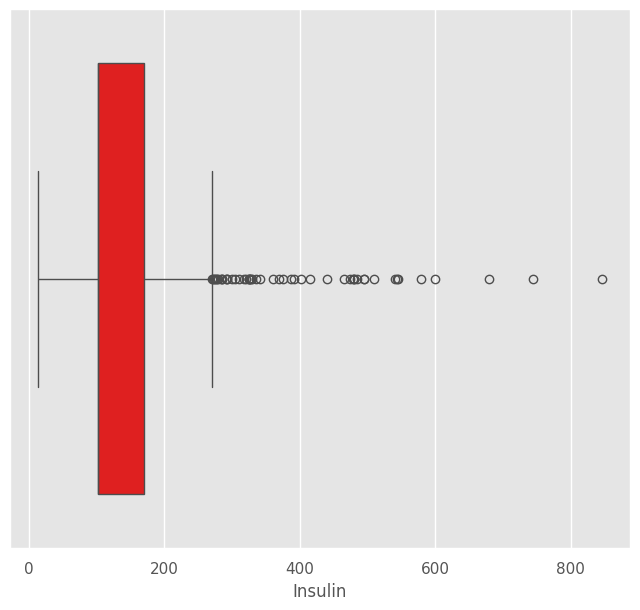

In [50]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Insulin,color='red')

In [51]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10)
lof.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1

<Axes: xlabel='Insulin'>

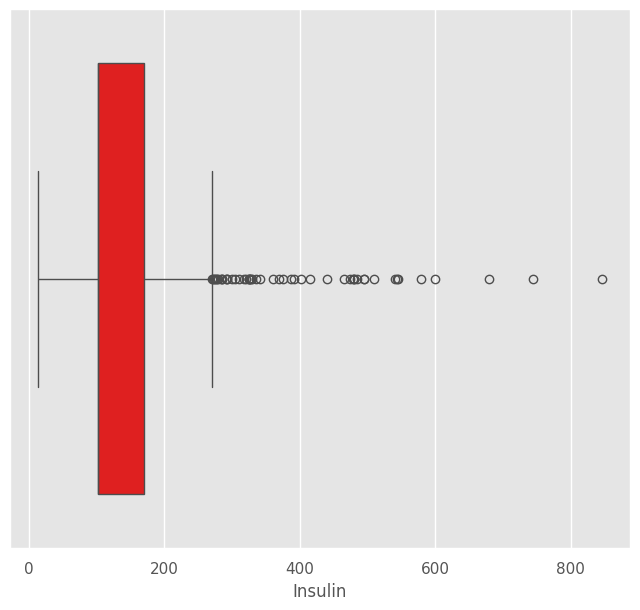

In [52]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Insulin,color='red')

<Axes: xlabel='BloodPressure'>

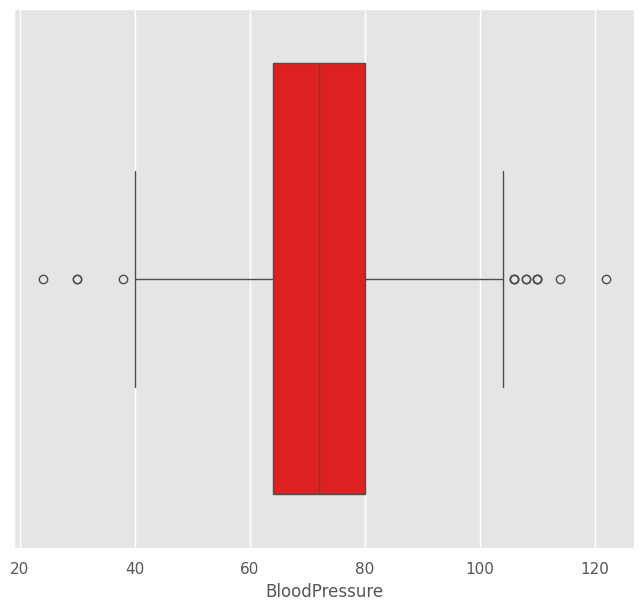

In [53]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.BloodPressure,color='red') 

<Axes: xlabel='SkinThickness'>

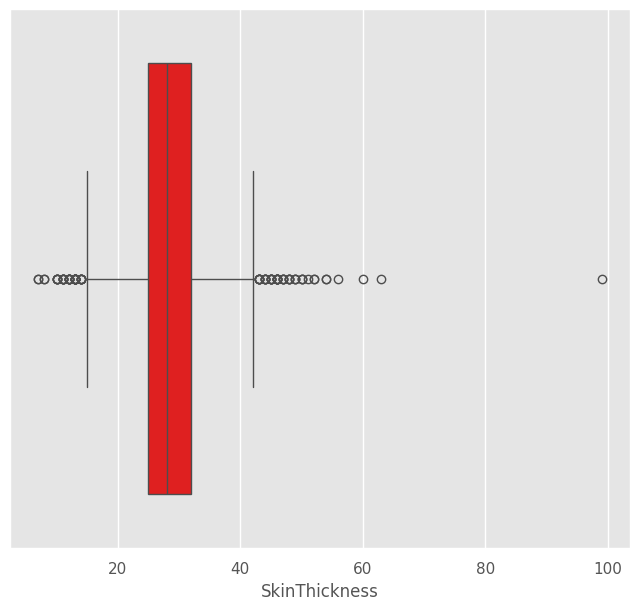

In [54]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.SkinThickness ,color='red') 

<Axes: xlabel='DiabetesPedigreeFunction'>

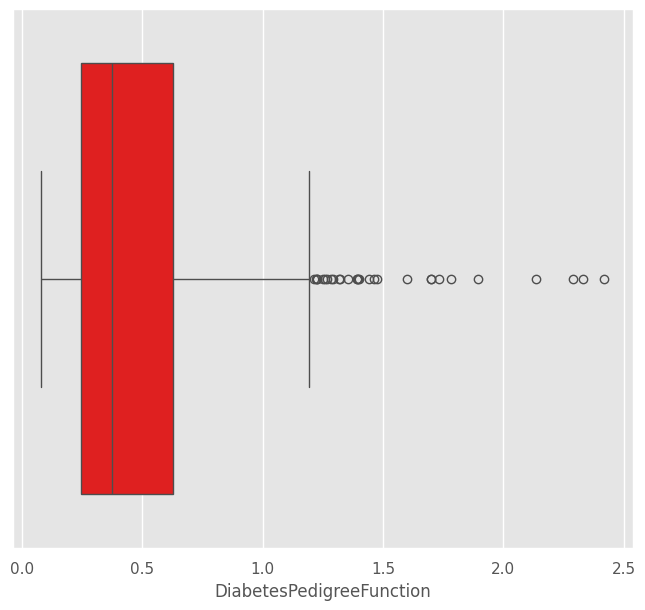

In [55]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.DiabetesPedigreeFunction,color='red')  

<Axes: xlabel='BMI'>

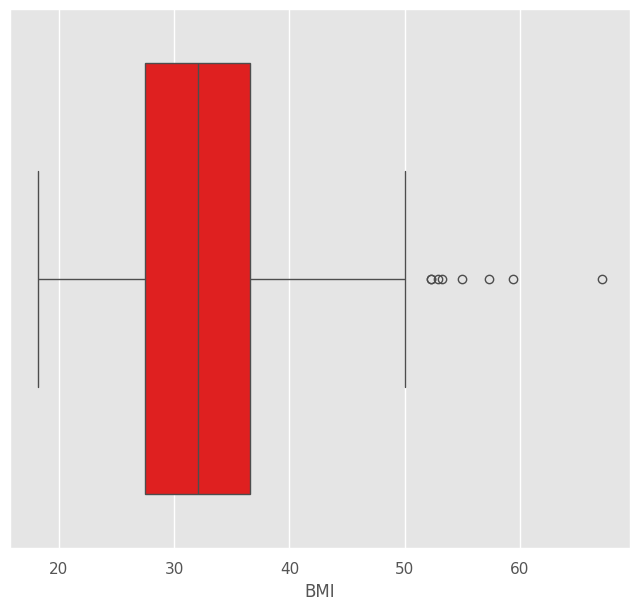

In [56]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.BMI,color='red')  

<Axes: xlabel='Age'>

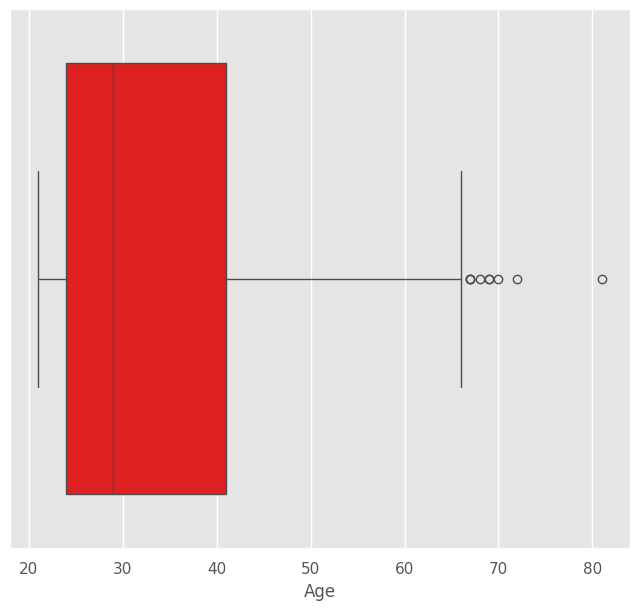

In [57]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Age,color='red')  

<Axes: xlabel='Pregnancies'>

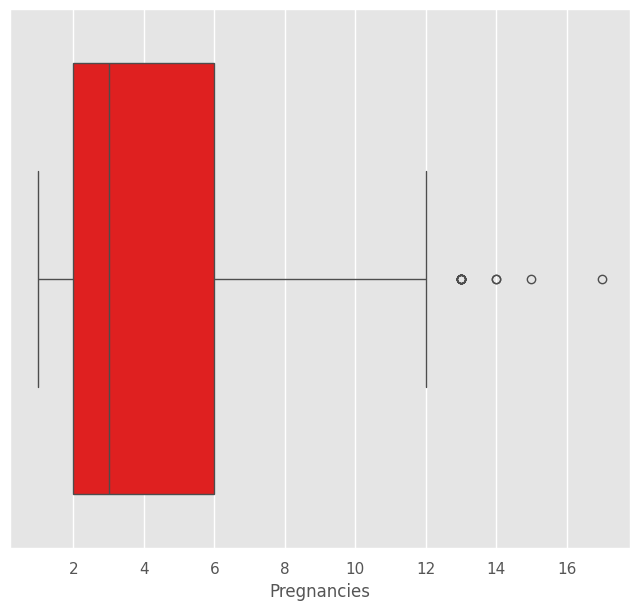

In [58]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Pregnancies,color='red')  

<Axes: xlabel='Glucose'>

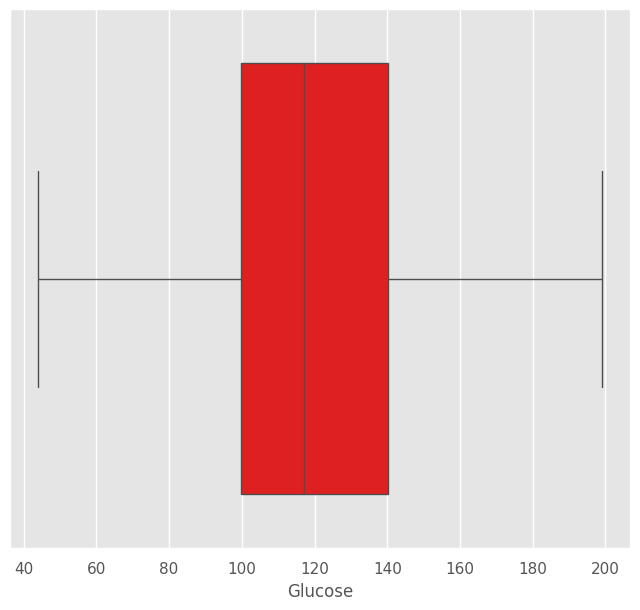

In [59]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df.Glucose,color='red')   

In [60]:
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:30]

array([-3.30540654, -3.06509976, -2.48947632, -2.38250393, -2.15557018,
       -2.11501347, -2.08356175, -2.01128734, -1.95386655, -1.83559384,
       -1.74974237, -1.7330214 , -1.71017168, -1.70215105, -1.68722889,
       -1.64294601, -1.64180205, -1.61181746, -1.61067772, -1.60925053,
       -1.60214364, -1.59998552, -1.58761193, -1.5783214 , -1.54655494,
       -1.5188879 , -1.510242  , -1.50390135, -1.4917993 , -1.4908793 ])

In [61]:
threshold = np.sort(df_scores)[7]

In [62]:
threshold

-2.011287339616332

In [63]:
outlier = df_scores > threshold # all of them are outliers

In [64]:
df = df[outlier]

In [65]:
df.shape #removed outliers shape is now 760 and not 768

(760, 9)

# **Feature Enginnering**

In [66]:
NewBMI = pd.Series(['Underweight',
                    'Normal',
                    'Overweight',
                    'Obesity 1',
                    'Obesity 2',
                    'Obesity 3'
                   ], dtype='category')

In [67]:
NewBMI

0    Underweight
1         Normal
2     Overweight
3      Obesity 1
4      Obesity 2
5      Obesity 3
dtype: category
Categories (6, object): ['Normal', 'Obesity 1', 'Obesity 2', 'Obesity 3', 'Overweight', 'Underweight']

In [68]:
df['NewBMI'] = NewBMI
df.loc[df["BMI"]  < 18.5, "NewBMI"]  =  NewBMI[0]
df.loc[(df["BMI"] > 18.5) & df["BMI"]<= 24.9, "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & df["BMI"]<= 29.9, "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & df["BMI"]<= 34.9, "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & df["BMI"]<= 39.9, "NewBMI"] = NewBMI[4]
df.loc[df["BMI"]  > 39.9, "NewBMI"]  =  NewBMI[5]

In [69]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome     NewBMI  
0                     0.627   50        1  Obesity 2  
1                     0.351   31        0  Obesity 2  
2                     0.672   32        1  Obesity 2  
3                     0.167   21        0  Obesity 2  
4                     2.288   33        1  Obesity 3

In [70]:
# 16 to 166 is normal Insulin
def set_insulin(row):
    return 'Normal' if row["Insulin"] >= 16 and row["Insulin"] <= 166 else 'Abnormal'

In [71]:
df = df.assign(NewInsulinScore = df.apply(set_insulin,axis=1))

In [72]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome     NewBMI NewInsulinScore  
0                     0.627   50        1  Obesity 2        Abnormal  
1                     0.351   31        0  Obesity 2          Normal  
2                     0.672   32        1  Obesity 2        Abnormal  
3                     0.167   21        0  Obesity 2          Normal  
4                     2.288   33        1  Obesity 3        Abnormal

In [73]:

# Some intervals were determined according to the glucose variable and these were assigned categorical variables.
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret"], dtype = "category")
df["NewGlucose"] = NewGlucose
df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]
df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]
df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]
df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [74]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome     NewBMI NewInsulinScore  \
0                     0.627   50        1  Obesity 2        Abnormal   
1                     0.351   31        0  Obesity 2          Normal   
2                     0.672   32        1  Obesity 2        Abnormal   
3                     0.167   21        0  Obesity 2          Normal   
4                     2.288   33        1  Obesity 3        Abnormal   

  NewGlucose  
0     Secret  
1     Normal  
2     Secret  
3     Normal  
4     Secret

# **One Hot Encoding**

In [75]:
df = pd.get_dummies(df,columns=['NewBMI','NewInsulinScore','NewGlucose'],drop_first=True)

In [76]:
df.columns.unique()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'NewBMI_Obesity 1',
       'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
       'NewBMI_Underweight', 'NewInsulinScore_Normal', 'NewGlucose_Normal',
       'NewGlucose_Overweight', 'NewGlucose_Secret'],
      dtype='object')

In [77]:
categorical_df = df[[ 'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3',
                    'NewBMI_Overweight','NewBMI_Underweight', 'NewInsulinScore_Normal',
                     'NewGlucose_Normal','NewGlucose_Overweight', 'NewGlucose_Secret']]

In [78]:
categorical_df.head()

NewBMI_Obesity 1  NewBMI_Obesity 2  NewBMI_Obesity 3  NewBMI_Overweight  \
0             False              True             False              False   
1             False              True             False              False   
2             False              True             False              False   
3             False              True             False              False   
4             False             False              True              False   

   NewBMI_Underweight  NewInsulinScore_Normal  NewGlucose_Normal  \
0               False                   False              False   
1               False                    True               True   
2               False                   False              False   
3               False                    True               True   
4               False                   False              False   

   NewGlucose_Overweight  NewGlucose_Secret  
0                  False               True  
1                  False              False  
2                  False               True  
3                  False              False  
4                  False               True

In [79]:
categorical_df = categorical_df.astype(int)

In [80]:
categorical_df.head()

NewBMI_Obesity 1  NewBMI_Obesity 2  NewBMI_Obesity 3  NewBMI_Overweight  \
0                 0                 1                 0                  0   
1                 0                 1                 0                  0   
2                 0                 1                 0                  0   
3                 0                 1                 0                  0   
4                 0                 0                 1                  0   

   NewBMI_Underweight  NewInsulinScore_Normal  NewGlucose_Normal  \
0                   0                       0                  0   
1                   0                       1                  1   
2                   0                       0                  0   
3                   0                       1                  1   
4                   0                       0                  0   

   NewGlucose_Overweight  NewGlucose_Secret  
0                      0                  1  
1                      0                  0  
2                      0                  1  
3                      0                  0  
4                      0                  1

In [81]:
Y = df['Outcome']

X = df.drop(['Outcome', 'NewBMI_Obesity 1','NewBMI_Obesity 2', 
            'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
             'NewInsulinScore_Normal', 'NewGlucose_Normal','NewGlucose_Overweight',
             'NewGlucose_Secret'],axis=1)

In [82]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [83]:
X.shape

(760, 8)

In [84]:
cols = X.columns
index = X.index

In [85]:
X.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.5  33.6   
1          1.0     85.0           66.0           29.0    102.5  26.6   
2          8.0    183.0           64.0           32.0    169.5  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          5.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33

In [86]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns=cols, index=index)

In [87]:
X.head() #range of (0 , -1)

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0         0.75  0.770186          0.000       1.000000  1.000000  0.177778   
1        -0.50 -0.795031         -0.375       0.142857  0.000000 -0.600000   
2         1.25  1.639752         -0.500       0.571429  1.000000 -0.966667   
3        -0.50 -0.695652         -0.375      -0.714286 -0.126866 -0.433333   
4         0.50  0.496894         -2.000       1.000000  0.977612  1.233333   

   DiabetesPedigreeFunction       Age  
0                  0.672313  1.235294  
1                 -0.046906  0.117647  
2                  0.789577  0.176471  
3                 -0.526384 -0.470588  
4                  5.000651  0.235294

In [88]:
X = pd.concat([X,categorical_df],axis=1)

In [89]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'NewBMI_Obesity 1',
       'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
       'NewBMI_Underweight', 'NewInsulinScore_Normal', 'NewGlucose_Normal',
       'NewGlucose_Overweight', 'NewGlucose_Secret'],
      dtype='object')

In [90]:
X.head()

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0         0.75  0.770186          0.000       1.000000  1.000000  0.177778   
1        -0.50 -0.795031         -0.375       0.142857  0.000000 -0.600000   
2         1.25  1.639752         -0.500       0.571429  1.000000 -0.966667   
3        -0.50 -0.695652         -0.375      -0.714286 -0.126866 -0.433333   
4         0.50  0.496894         -2.000       1.000000  0.977612  1.233333   

   DiabetesPedigreeFunction       Age  NewBMI_Obesity 1  NewBMI_Obesity 2  \
0                  0.672313  1.235294                 0                 1   
1                 -0.046906  0.117647                 0                 1   
2                  0.789577  0.176471                 0                 1   
3                 -0.526384 -0.470588                 0                 1   
4                  5.000651  0.235294                 0                 0   

   NewBMI_Obesity 3  NewBMI_Overweight  NewBMI_Underweight  \
0                 0                  0                   0   
1                 0                  0                   0   
2                 0                  0                   0   
3                 0                  0                   0   
4                 1                  0                   0   

   NewInsulinScore_Normal  NewGlucose_Normal  NewGlucose_Overweight  \
0                       0                  0                      0   
1                       1                  1                      0   
2                       0                  0                      0   
3                       1                  1                      0   
4                       0                  0                      0   

   NewGlucose_Secret  
0                  1  
1                  0  
2                  1  
3                  0  
4                  1

In [91]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'NewBMI_Obesity 1',
       'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
       'NewBMI_Underweight', 'NewInsulinScore_Normal', 'NewGlucose_Normal',
       'NewGlucose_Overweight', 'NewGlucose_Secret'],
      dtype='object')

# **Train Test Splitting**

In [92]:
X_train,X_test ,Y_train,Y_test = train_test_split(X,Y, test_size=0.2,random_state=0)

In [93]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **LR**

In [94]:
log_reg = LogisticRegression()
log_reg.fit(X_train,Y_train)

LogisticRegression()

In [95]:
Y_pred = log_reg.predict(X_test)

In [96]:
accuracy_score(Y_train, log_reg.predict(X_train))

0.850328947368421

In [97]:
log_reg_acc =  accuracy_score(Y_test, log_reg.predict(X_test))
log_reg_acc 

0.875

In [98]:
confusion_matrix(Y_test, Y_pred)

array([[88,  8],
       [11, 45]])

In [99]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        96
           1       0.85      0.80      0.83        56

    accuracy                           0.88       152
   macro avg       0.87      0.86      0.86       152
weighted avg       0.87      0.88      0.87       152



# **KNN**

In [100]:
knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
Y_pred= knn.predict(X_test)
print(accuracy_score(Y_train, knn.predict(X_train)))
knn_acc = accuracy_score(Y_test, knn.predict(X_test))
print(accuracy_score(Y_test, knn.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.875
0.8421052631578947
[[81 15]
 [ 9 47]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        96
           1       0.76      0.84      0.80        56

    accuracy                           0.84       152
   macro avg       0.83      0.84      0.83       152
weighted avg       0.85      0.84      0.84       152



# **SVC**

In [101]:
svc = SVC(probability=True)
param = {
    'gamma':[0.0001,0.001,0.01,0.1],
    'C':[0.1,0.01,0.05,0.01,1,10,15,20,1.5]
}
grid_search = GridSearchCV(svc,param)
grid_search.fit(X_train,Y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 0.01, 0.05, 0.01, 1, 10, 15, 20, 1.5],
                         'gamma': [0.0001, 0.001, 0.01, 0.1]})

In [102]:
grid_search.best_params_

{'C': 20, 'gamma': 0.01}

In [103]:
grid_search.best_score_

0.8568215688931039

In [104]:
svc = SVC(C=1,gamma=0.01,probability=True)
svc.fit(X_train,Y_train)
Y_pred= svc.predict(X_test)
print(accuracy_score(Y_train, svc.predict(X_train)))
svc_acc = accuracy_score(Y_test, svc.predict(X_test))
print(accuracy_score(Y_test, svc.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.8355263157894737
0.8618421052631579
[[83 13]
 [ 8 48]]
              precision    recall  f1-score   support

           0       0.91      0.86      0.89        96
           1       0.79      0.86      0.82        56

    accuracy                           0.86       152
   macro avg       0.85      0.86      0.85       152
weighted avg       0.87      0.86      0.86       152



# **DT**

In [105]:
DT = DecisionTreeClassifier(max_features='sqrt')
DT.fit(X_train,Y_train)
Y_pred = DT.predict(X_test)
print(accuracy_score(Y_train, DT.predict(X_train)))
dt_acc = accuracy_score(Y_test, DT.predict(X_test))
print(accuracy_score(Y_test, DT.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

1.0
0.8881578947368421
[[89  7]
 [10 46]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        96
           1       0.87      0.82      0.84        56

    accuracy                           0.89       152
   macro avg       0.88      0.87      0.88       152
weighted avg       0.89      0.89      0.89       152



In [106]:
# hyper param tuning
grid_param ={
    'criterion':['gini','entropy'],
    'max_depth':[3,5,7,10],
    'splitter':['random','best'],
    'min_samples_leaf':[1,2,3,4,5,6],
    'min_samples_split':[1,2,3,4,5,6],
    'max_features':['auto','sqrt','log2']
}
grid_search_dt = GridSearchCV(DT,grid_param, cv=6,n_jobs=-1,verbose=1)
grid_search_dt.fit(X_train,Y_train)

Fitting 6 folds for each of 1728 candidates, totalling 10368 fits


GridSearchCV(cv=6, estimator=DecisionTreeClassifier(max_features='sqrt'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [1, 2, 3, 4, 5, 6],
                         'splitter': ['random', 'best']},
             verbose=1)

In [107]:
grid_search_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'splitter': 'best'}

In [108]:
grid_search_dt.best_score_

0.8650909208567915

In [109]:
DT = grid_search_dt.best_estimator_
Y_pred = DT.predict(X_test)
print(accuracy_score(Y_train, DT.predict(X_train)))
dt_acc = accuracy_score(Y_test, DT.predict(X_test))
print(accuracy_score(Y_test, DT.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.8914473684210527
0.9210526315789473
[[93  3]
 [ 9 47]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        96
           1       0.94      0.84      0.89        56

    accuracy                           0.92       152
   macro avg       0.93      0.90      0.91       152
weighted avg       0.92      0.92      0.92       152



# **RFC**

In [110]:
rand_clf = RandomForestClassifier(criterion = 'entropy', max_depth = 5, max_features = 'sqrt', min_samples_leaf = 6, min_samples_split = 4, n_estimators = 150)
rand_clf.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=6,
                       min_samples_split=4, n_estimators=150)

In [111]:
# hyper param tuning
grid_param ={
    'criterion':['gini','entropy'],
    'max_depth':[3,5,7,10],
    'n_estimators':[100,150,170,200],
    'min_samples_leaf':[1,2,3,4,5,6],
    'min_samples_split':[1,2,3,4,5,6],
    'max_features':['auto','sqrt','log2']
}
grid_search_rf = GridSearchCV(rand_clf,grid_param, cv=6,n_jobs=-1,verbose=1)
grid_search_rf.fit(X_train,Y_train)

Fitting 6 folds for each of 3456 candidates, totalling 20736 fits


GridSearchCV(cv=6,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=5,
                                              min_samples_leaf=6,
                                              min_samples_split=4,
                                              n_estimators=150),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [1, 2, 3, 4, 5, 6],
                         'n_estimators': [100, 150, 170, 200]},
             verbose=1)

In [112]:
Y_pred = rand_clf.predict(X_test)
print(accuracy_score(Y_train, rand_clf.predict(X_train)))
rand_acc = accuracy_score(Y_test, rand_clf.predict(X_test))
print(accuracy_score(Y_test, rand_clf.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.9111842105263158
0.9144736842105263
[[88  8]
 [ 5 51]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93        96
           1       0.86      0.91      0.89        56

    accuracy                           0.91       152
   macro avg       0.91      0.91      0.91       152
weighted avg       0.92      0.91      0.91       152



# **GBC**

In [113]:
gbc = GradientBoostingClassifier()

parameters = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.001, 0.1, 1, 10],
    'n_estimators': [100, 150, 180, 200],
}

grid_search_gbc = GridSearchCV(gbc, parameters, cv = 3, n_jobs = -1, verbose = 1)
grid_search_gbc.fit(X_train, Y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.1, 1, 10],
                         'loss': ['log_loss', 'exponential'],
                         'n_estimators': [100, 150, 180, 200]},
             verbose=1)

In [114]:
grid_search_gbc.best_params_

{'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 180}

In [115]:
gbc = GradientBoostingClassifier(learning_rate = 0.1, loss = 'log_loss', n_estimators = 100)
gbc.fit(X_train,Y_train)

GradientBoostingClassifier()

In [116]:
grid_search_gbc.best_score_

0.8651335576907444

In [117]:
gbc = grid_search_gbc.best_estimator_
Y_pred = gbc.predict(X_test)
print(accuracy_score(Y_train, gbc.predict(X_train)))
gbc_acc = accuracy_score(Y_test, gbc.predict(X_test))
print(accuracy_score(Y_test, gbc.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.9950657894736842
0.9342105263157895
[[92  4]
 [ 6 50]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        96
           1       0.93      0.89      0.91        56

    accuracy                           0.93       152
   macro avg       0.93      0.93      0.93       152
weighted avg       0.93      0.93      0.93       152



# **XGB**

In [118]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/153.9 MB 6.5 MB/s eta 0:00:24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/153.9 MB 26.3 MB/s eta 0:00:06

     ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/153.9 MB 72.7 MB/s eta 0:00:03

     ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/153.9 MB 173.2 MB/s eta 0:00:01

     ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.5/153.9 MB 174.6 MB/s eta 0:00:01

     ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/153.9 MB 173.9 MB/s eta 0:00:01

     ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/153.9 MB 176.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/153.9 MB 176.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 61.8/153.9 MB 176.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 73.7/153.9 MB 172.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 79.7/153.9 MB 171.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━ 85.9/153.9 MB 176.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 98.0/153.9 MB 176.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 104.1/153.9 MB 177.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 116.1/153.9 MB 174.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━ 121.9/153.9 MB 170.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 134.2/153.9 MB 177.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 140.3/153.9 MB 177.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 152.4/153.9 MB 176.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 153.9/153.9 MB 172.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 3.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [119]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate = 0.01, max_depth = 10, n_estimators = 180)

xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [120]:
Y_pred = xgb.predict(X_test)
print(accuracy_score(Y_train, xgb.predict(X_train)))
xgb_acc = accuracy_score(Y_test, xgb.predict(X_test))
print(accuracy_score(Y_test, gbc.predict(X_test)))
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

0.9819078947368421
0.9342105263157895
[[88  8]
 [ 8 48]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        96
           1       0.86      0.86      0.86        56

    accuracy                           0.89       152
   macro avg       0.89      0.89      0.89       152
weighted avg       0.89      0.89      0.89       152



# **Model Comparison**

In [121]:
models = pd.DataFrame({
    'Model': ['Logistic Regression',
              'KNN',
              'SVM', 
              'Decision Tree Classifier',
              'Random Forest Classifier',
              'Gradient Boosting Classifier',
              'XgBoost'
             ],
    'Score': [100*round(log_reg_acc,4),
              100*round(knn_acc,4),
              100*round(svc_acc,4), 
              100*round(dt_acc,4),
              100*round(rand_acc,4), 
              100*round(gbc_acc,4),
              100*round(xgb_acc,4)
             ]
})
models.sort_values(by = 'Score', ascending = False)

Model  Score
5  Gradient Boosting Classifier  93.42
3      Decision Tree Classifier  92.11
4      Random Forest Classifier  91.45
6                       XgBoost  89.47
0           Logistic Regression  87.50
2                           SVM  86.18
1                           KNN  84.21

In [122]:
import pickle
# Identify the model with the highest score
best_model_name = models.iloc[0]['Model']

# Map the model names to the actual model objects
model_mapping = {
    'Logistic Regression': log_reg,
    'KNN': knn,
    'SVM': svc,
    'Decision Tree Classifier': DT,
    'Random Forest Classifier': rand_clf,
    'Gradient Boosting Classifier': gbc,
    'XgBoost': xgb
}

# Get the best model object based on the name
best_model = model_mapping[best_model_name]

# Dump the best model into a pickle file
with open('/kaggle/working/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print(f"The best model ({best_model_name}) has been saved to 'best_model.pkl'.")

The best model (Logistic Regression) has been saved to 'best_model.pkl'.


# **ROC Curve**

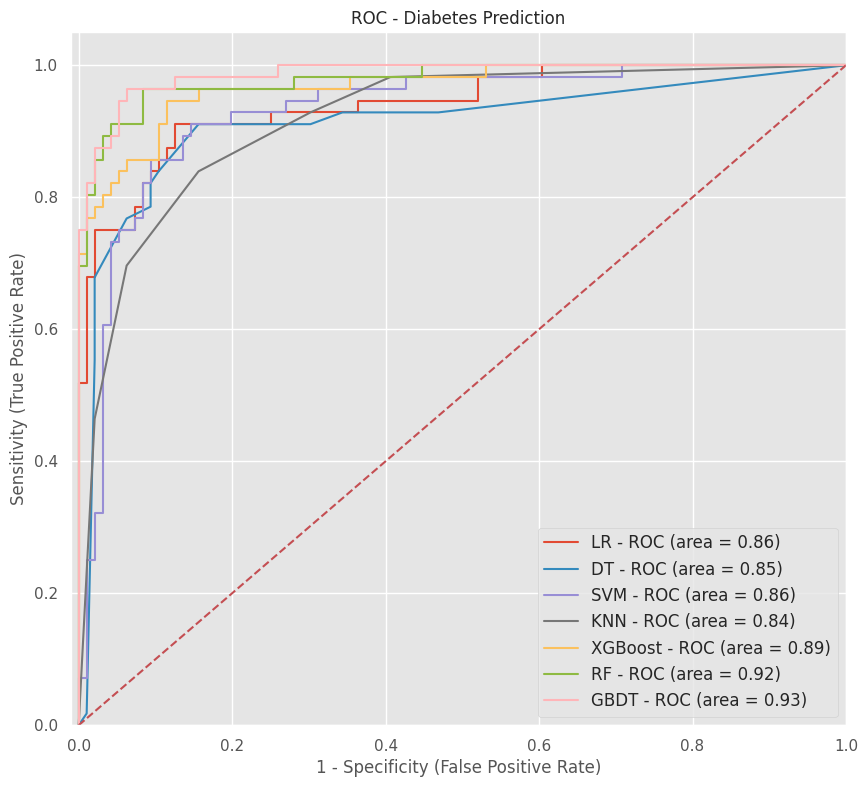

In [123]:
from sklearn import metrics
plt.figure(figsize=(10,9))
models = [
{
    'label': 'LR',
    'model': log_reg,
},
{
    'label': 'DT',
    'model': DT,
},
{
    'label': 'SVM',
    'model': svc,
},
{
    'label': 'KNN',
    'model': knn,
},
{
    'label': 'XGBoost',
    'model': xgb,
},
{
    'label': 'RF',
    'model': rand_clf,
},
{
    'label': 'GBDT',
    'model': gbc,
}
]
for m in models:
    model = m['model'] 
    model.fit(X_train, Y_train) 
    Y_pred = model.predict(X_test) 
    fpr1, tpr1, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(Y_test,model.predict(X_test))
    plt.plot(fpr1, tpr1, label='%s - ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Diabetes Prediction', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("/kaggle/working/roc_diabetes.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

# **Performance Evaluation**

mean_accuracies: [87.5, 92.11, 86.18, 84.21, 89.47, 91.45, 93.42]
mean_roc: [86.00999999999999, 85.86, 86.09, 84.15, 88.69, 91.0, 92.56]


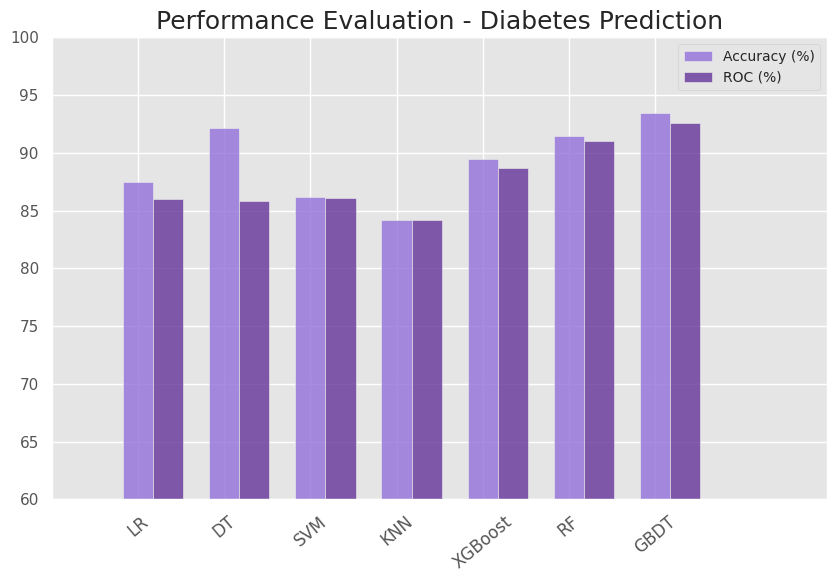

In [124]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'LR',
    'model': log_reg,
},
{
    'label': 'DT',
    'model': DT,
},
{
    'label': 'SVM',
    'model': svc,
},
{
    'label': 'KNN',
    'model': knn,
},
{
    'label': 'XGBoost',
    'model': xgb,
},
{
    'label': 'RF',
    'model': rand_clf,
},
{
    'label': 'GBDT',
    'model': gbc,
}
]

means_roc = []
means_accuracy = [100*round(log_reg_acc,4),
                  100*round(dt_acc,4),
                  100*round(svc_acc,4), 
                  100*round(knn_acc,4), 
                  100*round(xgb_acc,4), 
                  100*round(rand_acc,4), 
                  100*round(gbc_acc,4)
                 ]

for m in models:
    model = m['model'] 
    model.fit(X_train, Y_train) 
    Y_pred=model.predict(X_test) 
    fpr1, tpr1, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(Y_test,model.predict(X_test))
    auc = 100*round(auc,4)
    means_roc.append(auc)

print(f'mean_accuracies: {means_accuracy}')
print(f'mean_roc: {means_roc}')

# data to plot
n_groups = 7 # 7 models
means_accuracy = tuple(means_accuracy)
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(10,6))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity,
color='mediumpurple',
label='Accuracy (%)')

rects2 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity,
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-1, 8])
plt.ylim([60, 100])

plt.title('Performance Evaluation - Diabetes Prediction', fontsize=18)
plt.xticks(index, ('LR', 'DT', 'SVM', 'KNN' ,'XGBoost', 'RF', 'GBDT'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.savefig("/kaggle/working/PE_diabetes.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()